In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import scipy
import os
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.utils import shuffle
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

In [4]:
full_data = pd.read_pickle('fully_labeled_traces_feats3_042224_baseline_corrected.pickle')
# region and indexing-related variables / functions
region_ids = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
       'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
       'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)',
       'PA (E)', 'PA (I)', 'NAc (DA)'] # populations
indices = {val: idx for idx, val in enumerate(region_ids)} # dictionary with IDs for remapping
agg_animals = ['3095', '3096', '3097', '4013', '4014', '4015', '4016', '91R2', '30L', '30B', '30R2', '29L']
obs_animals = ['30R2', '29L', '87L2', '86L']
non_animals = ['87R2', '87B', '87L', '86L2']

In [5]:
full_data['3095_d1_balbc_t1'].head()

,PrL (E),PrL (I),vLS (E),vLS (I),POA (E),POA (I),BNST (E),BNST (I),AH (E),AH (I),...,PAG (I),PMv (E),PMv (I),LHb (E),LHb (I),PA (E),PA (I),NAc (DA),unsupervised labels,attack labels
0,0.504232,0.195427,0.106711,0.219520,0.371472,0.347229,NaN,NaN,0.591867,0.059156,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.215806,10.0,0
1,0.344082,0.069099,0.004813,0.200810,0.324398,0.199272,NaN,NaN,0.397944,0.022272,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.012951,10.0,0
2,0.212330,-0.017433,-0.073643,0.162713,0.254445,0.077471,NaN,NaN,0.229036,-0.013280,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.144630,10.0,0
3,0.108760,-0.064656,-0.128832,0.111516,0.172371,-0.018593,NaN,NaN,0.087817,-0.044866,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.259369,10.0,0
4,0.033157,-0.073057,-0.160926,0.053504,0.088934,-0.089343,NaN,NaN,-0.023039,-0.069850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.333701,10.0,0


In [6]:
regions_sample = ['PrL (E)', 'PrL (I)', 'vLS (E)', 'vLS (I)', 'POA (E)', 'POA (I)',
       'BNST (E)', 'BNST (I)', 'AH (E)', 'AH (I)', 'MeA (E)', 'MeA (I)',
       'VMH (E)', 'VMH (I)', 'PAG (E)', 'PAG (I)', 'PMv (E)', 'PMv (I)', 'LHb (E)', 'LHb (I)',
       'PA (E)', 'PA (I)']
region_ids_sorted = sorted(regions_sample, key=lambda x: x.split()[-1])
sample = full_data['91R2_d1_balbc_t1']

In [7]:
def format4analysis(full_data, animal_ID, binary_labels='attack labels', exp='aggression'):

    sessions = list(full_data.keys())
    region_index, region_id = pd.factorize(region_ids)
    epochs = [[0, 3], [3, 6], [6, 9], [9, 12], [12, 15], [15, 18], [18, 21], [21,24], [24, 28]]
    f = np.max([full_data[session].shape[0] for session in sessions])

    traces_lib = np.empty((f, len(region_index), 27))
    traces_lib[:] = np.nan

    # package recordings into traces_lib array

    if exp == 'aggression':
        sessions = [x for x in sessions if '_balbc_' in x or '_mCD1_' in x]
    elif exp == 'observation':
        sessions = [x for x in sessions if '_obs_' in x or '_OBSmCD1_' in x]
    elif exp == 'nonsocial':
        sessions = [x for x in sessions if '_toy_' in x or '_toyCD1_' in x]
    else:
        raise Exception("Please specify experience type as 'aggression' or 'observation'.")

    for i, sesh in enumerate([x for x in sessions if animal_ID in x]):

        # format traces from each session to fit the big nan array above
        s = full_data[sesh]
        not_na_cols = s.columns[s.notna().all()].tolist()
        if s.shape[0] < f:
            nan_pad = np.zeros((f-s.shape[0], s.shape[1]))
            nan_pad[:] = np.nan
            nan_pad = pd.DataFrame(nan_pad, columns=s.columns)
            s = pd.concat([s, nan_pad], axis=0)

        # copy columns at specific locations
        for idx, roi in zip(region_index, region_id):
            try: 
                traces_lib[:, idx, i] = s[roi]
            except KeyError:
                traces_lib[:, idx, i] = np.nan

    # separate into epochs

    d1 = traces_lib[:, :, epochs[0][0]:epochs[0][1]]
    d2 = traces_lib[:, :, epochs[1][0]:epochs[1][1]]
    d3 = traces_lib[:, :, epochs[2][0]:epochs[2][1]]
    d4 = traces_lib[:, :, epochs[3][0]:epochs[3][1]]
    d5 = traces_lib[:, :, epochs[4][0]:epochs[4][1]]
    d6 = traces_lib[: ,:, epochs[5][0]:epochs[5][1]]
    d7 = traces_lib[: ,:, epochs[6][0]:epochs[6][1]]
    d8 = traces_lib[: ,:, epochs[7][0]:epochs[7][1]]
    d9 = traces_lib[: ,:, epochs[8][0]:epochs[8][1]]
    trial_comps = [d1, d2, d3, d4, d5, d6, d7, d8, d9] 

    return trial_comps, not_na_cols

def produce_XY(epoch, orig_idx):
    
    filtered_sessions = epoch[~np.isnan(epoch).all(axis=1)]
    
    X_idxs = [x for x in np.arange(filtered_sessions.shape[1]) if orig_idx != x]
    X = filtered_sessions[:, X_idxs]
    orig_X = X.copy()
    if np.isnan(X).any(axis=0).any(): # remove columns with nan
        has_nan = np.isnan(X).any(axis=0)
        X = X[:, ~has_nan]
    y_init = filtered_sessions[:, orig_idx]
    y = y_init.reshape(-1,1)

    return X, y

def fit_ridge(X, y, verbose=0):

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)

    # Define the hyperparameters to search over
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

    # Define ridge regression model
    model = Ridge(fit_intercept=True, normalize=True)

    # Use GridSearchCV to perform a grid search with cross-validation
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring=make_scorer(r2_score))

    # Fit the grid search to the training data
    grid_search.fit(X, y)

    # Get the best hyperparameters found by the grid search
    best_params = grid_search.best_params_
    if verbose == 1:
        print('Best hyperparameters:', grid_search.best_params_)
        print('Best score:', grid_search.best_score_)

    # Train a new SVM classifier using the best hyperparameters
    best_model = Ridge(**best_params, fit_intercept=True, normalize=True) # rbf
    
    return X_train, X_test, y_train, y_test, best_model, grid_search.best_score_

def string_mapper(string_list, index):
    """
    Maps a list of strings to indices in ascending order, and returns a function to retrieve the string for a given index.
    """
    index_map = {i: string_list[i] for i in range(len(string_list))}
    
    def get_string(index):
        """
        Returns the string corresponding to the given index in the mapping.
        """
        return index_map[index]
    
    return get_string(index)

def format_weights(fold_weights, global_weights, rois):
    
    if fold_weights.shape[0] < global_weights.shape[0]:
        truncated_weights = np.zeros((global_weights.shape[0]))
        pres_idxs, miss_idxs = get_indices(rois)
        truncated_weights[pres_idxs] = np.array(np.mean(fold_weights, axis=1))
        truncated_weights[miss_idxs] = np.nan
        return truncated_weights
    else:
        return np.mean(fold_weights, axis=1)
    
def get_indices(partial_list):
    present_indices = [indices[val] for val in partial_list if val in indices]
    not_present = [val for val in np.arange(len(region_ids)) if val not in present_indices]
    return present_indices, not_present
    
def add_nan_values(matrix, rois, n_features=22):
    
    if len(rois) < n_features: 
        
        # Get roi indices
        pres_idxs, miss_idxs = get_indices(rois)
        # Create a copy of the original matrix to avoid modifying it
        matrix_copy = matrix.copy()
        # Create a 1D boolean mask that indicates where to add NaN values
        nan_mask = np.zeros(matrix_copy.shape[2], dtype=bool)
        print(miss_idxs)
        nan_mask[miss_idxs] = True
        # Add NaN values to the matrix
        matrix_copy = np.insert(matrix_copy, miss_idxs, np.nan, axis=2)
                
        return matrix_copy
    
    else:
        
        return matrix
    
def permutation_test(model, X_train, y_train, X_test, y_test, coefficients, rois, region_idx, n_permutations=100):
    
    shuf_model = deepcopy(model)
    max_coefs = np.zeros((n_permutations, 22))
    shuf_kos = np.zeros((n_permutations, 22))
    
    # Perform the permutations
    for i in range(n_permutations):
        
        # Shuffle the target variable (y)
        y_shuffled = shuffle(y_train)

        # Fit the model to the shuffled data
        shuf_model.fit(X_train, y_shuffled)
        shuf_best_score = r2_score(y_test, shuf_model.predict(X_test))

        # Store the maximum coefficient from the shuffled data
        max_coefs[i, :] = format_shuffled_weights(shuf_model.coef_, max_coefs, rois, region_idx)
        
        # Do knockout on shuffled model
        shuf_knockouts = np.zeros((shuf_model.coef_.shape[1]))
        for shuf_idx in np.arange(X_train.shape[1]):
            shuf_ko_model = deepcopy(shuf_model)
            new_shuf_coef=shuf_ko_model.coef_.copy()
            new_shuf_coef[:, shuf_idx] = 0.
            shuf_ko_model.coef_ = new_shuf_coef
            shuf_y_pred = shuf_ko_model.predict(X_test)
            shuf_ko_score = r2_score(y_test, shuf_y_pred)
            if shuf_ko_score < 0:
                shuf_ko_score = 0
            shuf_knockout_score_difference = shuf_best_score - shuf_ko_score
            if shuf_knockout_score_difference < 0:
                shuf_knockout_score_difference = 0
            shuf_knockouts[shuf_idx] = shuf_knockout_score_difference
        shuf_knockouts = shuf_knockouts.reshape((1, shuf_model.coef_.shape[1]))
            
        shuf_kos[i, :] = format_shuffled_weights(shuf_knockouts, shuf_kos, rois, region_idx)
        
    return max_coefs, shuf_kos

1. Whole trace regression (behavior agnostic) using celltype counterpart 

In [8]:
animals = np.concatenate([agg_animals, obs_animals, non_animals])

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from warnings import simplefilter
import warnings

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning, FitFailedWarning

# Ignore DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
animal_scores = np.zeros((23, 27, len(animals)))
EI_regions = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])

for a, animal in enumerate(animals):

    print('Processing data for %s' % animal)
    
    # load animal data
    if a <= 11:
        exp = 'aggression'
    elif a <= 15: 
        exp = 'observation'
    else:
        exp = 'nonsocial'

    trial_comps, rois = format4analysis(full_data, animal, exp=exp)
    rois = rois[:-2]
    norm_indices = [i for i, item in enumerate(region_ids) if item in set(rois)]
    trial_comps = np.concatenate(trial_comps, axis=2)
    
    # create arrays for storage of weights and % drop across epochs
    epoch_scores = np.zeros((trial_comps.shape[1], trial_comps.shape[2]))
    epoch_scores[:] = np.nan
    epoch_weights = np.zeros((trial_comps.shape[1], trial_comps.shape[1], trial_comps.shape[2]))
    epoch_weights[:] = np.nan
    epoch_knockouts = np.zeros((trial_comps.shape[1], trial_comps.shape[1], trial_comps.shape[2]))
    epoch_knockouts[:] = np.nan

    # containers for cross-validated score, weights and knockouts
    
    for e in np.arange(trial_comps.shape[-1]):
        print('Beginning epoch %i...' % e)
        epoch = trial_comps[:, :, e]
        for region_idx, orig_idx in enumerate(norm_indices):
            if orig_idx in EI_regions:
                
                X, y = produce_XY(epoch, orig_idx)
                X = X[:, region_idx].reshape(-1,1)
                
                X_train, X_test, y_train, y_test, model, best_score = fit_ridge(X, y)
                model.fit(X, y)
            
                # save scores and such
                indices_without_region_idx = [x for x in norm_indices if orig_idx != x]
                epoch_weights[indices_without_region_idx, orig_idx, e] = model.coef_.flatten()
                if best_score<0:
                    best_score=0
                epoch_scores[orig_idx, e] = best_score

    animal_scores[:, :, a] = epoch_scores
    
animal_scores = animal_scores[EI_regions, :, :]

Processing data for 3095
Beginning epoch 0...
Beginning epoch 1...
Beginning epoch 2...
Beginning epoch 3...
Beginning epoch 4...
Beginning epoch 5...
Beginning epoch 6...
Beginning epoch 7...
Beginning epoch 8...
Beginning epoch 9...
Beginning epoch 10...
Beginning epoch 11...
Beginning epoch 12...
Beginning epoch 13...
Beginning epoch 14...
Beginning epoch 15...
Beginning epoch 16...
Beginning epoch 17...
Beginning epoch 18...
Beginning epoch 19...
Beginning epoch 20...
Beginning epoch 21...
Beginning epoch 22...
Beginning epoch 23...
Beginning epoch 24...
Beginning epoch 25...
Beginning epoch 26...
Processing data for 3096
Beginning epoch 0...
Beginning epoch 1...
Beginning epoch 2...
Beginning epoch 3...
Beginning epoch 4...
Beginning epoch 5...
Beginning epoch 6...
Beginning epoch 7...
Beginning epoch 8...
Beginning epoch 9...
Beginning epoch 10...
Beginning epoch 11...
Beginning epoch 12...
Beginning epoch 13...
Beginning epoch 14...
Beginning epoch 15...
Beginning epoch 16...
Be

In [11]:
agg_animal_scores = animal_scores[:, :, :12]
obs_animal_scores = animal_scores[:, :, 12:16]
non_animal_scores = animal_scores[:, :, 16:]

In [56]:
agg_animal_scores_baseline = np.nanmean(agg_animal_scores[:, :3, :], axis=1)
obs_animal_scores_baseline = np.nanmean(obs_animal_scores[:, :3, :], axis=1)
non_animal_scores_baseline = np.nanmean(non_animal_scores[:, :3, :], axis=1)

C:\Users\Jorge\AppData\Local\Temp\ipykernel_44312\996281939.py:1: RuntimeWarning: Mean of empty slice
  agg_animal_scores_baseline = np.nanmean(agg_animal_scores[:, :3, :], axis=1)


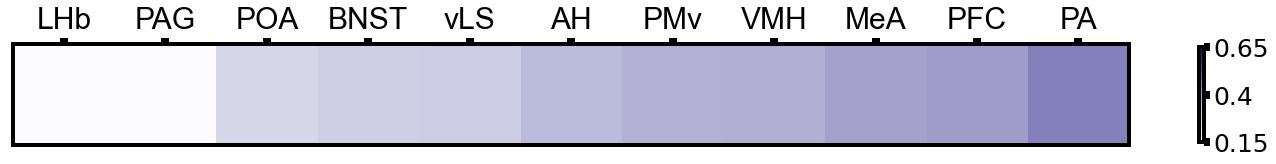

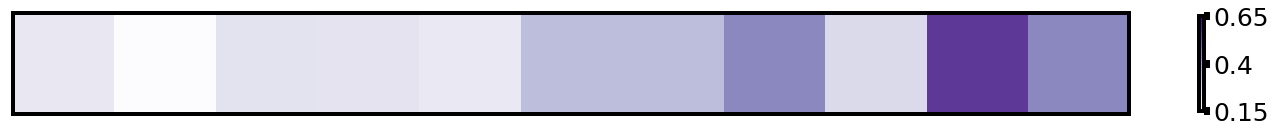

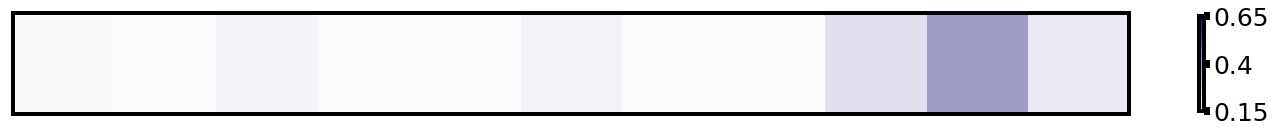

In [50]:
from matplotlib import colors
plt.close()
np.set_printoptions(precision=4, suppress=True)
EI_region_labels = ['PFC', 'vLS', 'POA', 'BNST', 'AH', 'MeA', 'VMH', 'PAG', 'PMv', 'LHb', 'PA']
n = len(EI_regions_labels)
cmap = 'Purples'

# within-day change

weights = np.nanmean(agg_animal_scores_baseline, axis=1)
ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
# weights_sorted[pvalues > 0.05] = 0
vmin = 0.15
vmax = 0.65
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(25, 5))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=np.linspace(vmin, vmax, 3))
cbar.set_ticklabels(np.linspace(vmin, vmax, 3))
# ax.set_title('Baseline accuracy of I→E encoding', fontfamily='Arial', weight='bold', fontsize=45)
ax.set_xticks(np.arange(n), np.array(EI_region_labels)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
ax.set_yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig('.\\retreat_figs\\agg_baseline_encoding.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(obs_animal_scores_baseline, axis=1)
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
# weights_sorted[pvalues > 0.05] = 0
vmin = 0.15
vmax = 0.65
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(25, 5))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=np.linspace(vmin, vmax, 3))
cbar.set_ticklabels(np.linspace(vmin, vmax, 3))
# plt.xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig('.\\retreat_figs\\obs_baseline_encoding.svg', dpi=600, bbox_inches='tight')

weights = np.nanmean(non_animal_scores_baseline, axis=1)
# ascending_idx = np.argsort(weights)
weights_sorted = weights[ascending_idx]
# weights_sorted[4] = 0
vmin = 0.15
vmax = 0.65
norm = colors.Normalize(vmin=vmin, vmax=vmax)
fig, ax = plt.subplots(figsize=(25, 5))
plt.imshow(weights_sorted.reshape(-1,1).T,cmap=cmap, norm=norm)
cbar=plt.colorbar(shrink=0.35, ticks=np.linspace(vmin, vmax, 3))
cbar.set_ticklabels(np.linspace(vmin, vmax, 3))
# plt.xticks(np.arange(n), np.array(regions_without_label)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=30);
plt.xticks([])
plt.yticks([])
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.savefig('.\\retreat_figs\\non_baseline_encoding.svg', dpi=600, bbox_inches='tight')




In [57]:
from scipy import stats
# Assuming your vectors are named vector1, vector2, and vector3
for r, roi in enumerate(EI_region_labels):
    print(' ##### %s ##### ' % roi)
    agg_roi_activity = agg_animal_scores_baseline[r, :][np.isnan(agg_animal_scores_baseline[r, :])==False]
    obs_roi_activity = obs_animal_scores_baseline[r, :][np.isnan(obs_animal_scores_baseline[r, :])==False]
    non_roi_activity = non_animal_scores_baseline[r, :][np.isnan(non_animal_scores_baseline[r, :])==False]

    # Test for normality
    _, p_agg = stats.shapiro(agg_roi_activity)
    _, p_obs = stats.shapiro(obs_roi_activity)
    _, p_non = stats.shapiro(non_roi_activity)

    # If the p-value is greater than 0.05, the data is normally distributed
    if p_agg > 0.05 and p_obs > 0.05 and p_non > 0.05:
        # Perform t-tests
        _, p_agg_non = stats.ttest_ind(agg_roi_activity, non_roi_activity)
        _, p_obs_non = stats.ttest_ind(obs_roi_activity, non_roi_activity)
        print(f"agg vs non: t-test p-value = {p_agg_non}")
        print(f"obs vs non: t-test p-value = {p_obs_non}")
    else:
        # Perform Wilcoxon rank-sum tests
        _, p_agg_non = stats.ranksums(agg_roi_activity, non_roi_activity)
        _, p_obs_non = stats.ranksums(obs_roi_activity, non_roi_activity)
        print(f"agg vs non: Wilcoxon rank-sum test p-value = {p_agg_non}")
        print(f"obs vs non: Wilcoxon rank-sum test p-value = {p_obs_non}")

 ##### PFC ##### 
agg vs non: t-test p-value = 0.928459773248613
obs vs non: t-test p-value = 0.032726395377616756
 ##### vLS ##### 
agg vs non: t-test p-value = 0.09309175469535172
obs vs non: t-test p-value = 0.3619099102765417
 ##### POA ##### 
agg vs non: t-test p-value = 0.2809563965862806
obs vs non: t-test p-value = 0.2568102072226785
 ##### BNST ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.007209570764742526
obs vs non: Wilcoxon rank-sum test p-value = 0.0832645166635504
 ##### AH ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.20309178757716784
obs vs non: Wilcoxon rank-sum test p-value = 0.14891467317876572
 ##### MeA ##### 
agg vs non: t-test p-value = 0.17809921292401124
obs vs non: t-test p-value = 0.8003582484935446
 ##### VMH ##### 
agg vs non: t-test p-value = 0.01940696547170022
obs vs non: t-test p-value = 0.02031239224582379
 ##### PAG ##### 
agg vs non: Wilcoxon rank-sum test p-value = 0.308179547467054
obs vs non: Wilcoxon rank-sum test p-value = 0.5

C:\Users\Jorge\AppData\Local\Temp\ipykernel_47036\3158191967.py:20: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\Jorge\AppData\Local\Temp\ipykernel_47036\3158191967.py:45: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()
C:\Users\Jorge\AppData\Local\Temp\ipykernel_47036\3158191967.py:68: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


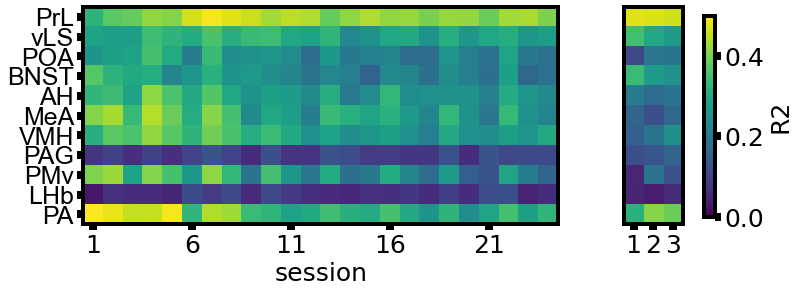

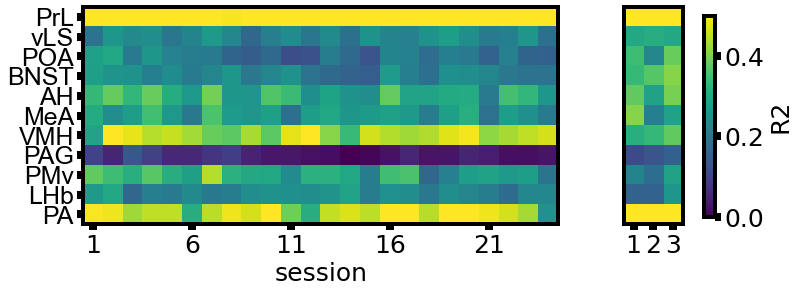

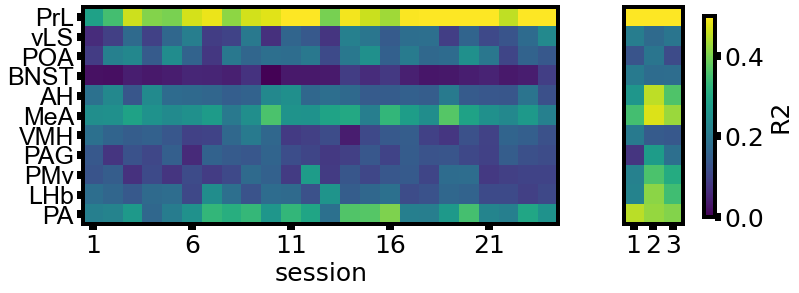

In [74]:
plt.close()
# Create a 10x27 grid and a 10x3 grid
grid1 = plt.GridSpec(11, 27)
grid2 = plt.GridSpec(11, 3)

# Create the figure
fig = plt.figure(figsize=(40, 4))  # Adjust the figure size as needed
# Add subplots to the grids
ax1 = fig.add_subplot(grid1[:, :-8])  # First grid, leaving space for the second one
ax2 = fig.add_subplot(grid2[:, :])     # Second grid
# Plot something in each subplot if needed
ax1.imshow(np.nanmean(agg_animal_scores[:, :-3, :], axis=2), vmin=0, vmax=0.5)
ax1.set_yticks(np.arange(11), [region_ids[idx].split(' ')[0] for idx in np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])], fontfamily='Arial');
# ax1.set_title('BC')
ax1.set_xticks(np.linspace(0, 20, 5).astype(int), np.linspace(1, 21, 5).astype(int))
ax1.set_xlabel('session')
ax2.imshow(np.nanmean(agg_animal_scores[:, -3:, :], axis=2), vmin=0, vmax=0.5)
ax2.set_yticks([])
ax2.set_xticks(np.arange(3), np.arange(1, 4).astype(int))
plt.tight_layout()
# Create colorbar
from matplotlib.cm import viridis
from matplotlib.colors import Normalize
cmap = viridis
norm = Normalize(vmin=0, vmax=0.5)  # Set the color scale from 0 to 0.5
cbar_ax = fig.add_axes([0.53, 0.15, 0.004, 0.7])  # Adjust the colorbar position as needed
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, shrink=0.6)
cbar.set_label("R2")
plt.savefig('.\\retreat_figs\\agg_animal_scores.svg', dpi=600, bbox_inches='tight')

# Create the figure
fig = plt.figure(figsize=(40, 4))  # Adjust the figure size as needed
# Add subplots to the grids
ax1 = fig.add_subplot(grid1[:, :-8])  # First grid, leaving space for the second one
ax2 = fig.add_subplot(grid2[:, :])     # Second grid
# Plot something in each subplot if needed
ax1.imshow(np.nanmean(obs_animal_scores[:, :-3, :], axis=2), vmin=0, vmax=0.5)
ax1.set_yticks(np.arange(11), [region_ids[idx].split(' ')[0] for idx in np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])], fontfamily='Arial');
# ax1.set_title('BC')
ax1.set_xticks(np.linspace(0, 20, 5).astype(int), np.linspace(1, 21, 5).astype(int))
ax1.set_xlabel('session')
ax2.imshow(np.nanmean(obs_animal_scores[:, -3:, :], axis=2), vmin=0, vmax=0.5)
ax2.set_yticks([])
ax2.set_xticks(np.arange(3), np.arange(1, 4).astype(int))
plt.tight_layout()
# Create colorbar
cmap = viridis
norm = Normalize(vmin=0, vmax=0.5)  # Set the color scale from 0 to 0.5
cbar_ax = fig.add_axes([0.53, 0.15, 0.004, 0.7])  # Adjust the colorbar position as needed
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, shrink=0.6)
cbar.set_label("R2")
plt.savefig('.\\retreat_figs\\obs_animal_scores.svg', dpi=600, bbox_inches='tight')

# Create the figure
fig = plt.figure(figsize=(40, 4))  # Adjust the figure size as needed
# Add subplots to the grids
ax1 = fig.add_subplot(grid1[:, :-8])  # First grid, leaving space for the second one
ax2 = fig.add_subplot(grid2[:, :])     # Second grid
# Plot something in each subplot if needed
ax1.imshow(np.nanmean(non_animal_scores[:, :-3, :], axis=2), vmin=0, vmax=0.5)
ax1.set_yticks(np.arange(11), [region_ids[idx].split(' ')[0] for idx in np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])], fontfamily='Arial');
# ax1.set_title('BC')
ax1.set_xticks(np.linspace(0, 20, 5).astype(int), np.linspace(1, 21, 5).astype(int))
ax1.set_xlabel('session')
ax2.imshow(np.nanmean(non_animal_scores[:, -3:, :], axis=2), vmin=0, vmax=0.5)
ax2.set_yticks([])
ax2.set_xticks(np.arange(3), np.arange(1, 4).astype(int))
plt.tight_layout()
# Create colorbar
cmap = viridis
norm = Normalize(vmin=0, vmax=0.5)  # Set the color scale from 0 to 0.5
cbar_ax = fig.add_axes([0.53, 0.15, 0.004, 0.7])  # Adjust the colorbar position as needed
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax, shrink=0.6)
cbar.set_label("R2")
plt.savefig('.\\retreat_figs\\non_animal_scores.svg', dpi=600, bbox_inches='tight')


In [90]:
# stats testing with Linear mixed model

all_tables = {}
sessions2exclude = -3
total_sessions = 27 + sessions2exclude
new_region_ids = np.array([region_ids[idx].split(' ')[0] for idx in EI_regions])
weights2map = np.transpose(non_animal_scores[:, :sessions2exclude, :], [1,0,2])
n_animals = len(non_animals)

# model framework

def fit_model(df):
    results = {}
    # Create a mixed linear model using smf.mixedlm
    mixed_lm = smf.mixedlm(
        formula="dependent_variable ~ session_trial + cum_trial", # add attacks at some point
        groups="subject",
        data=df
    )

    # Fit the model
    mixed_lm_fit = mixed_lm.fit()

    # Print the summary of the model
    print(mixed_lm_fit.summary())
    
    return mixed_lm_fit

# prep table
for r, roi in enumerate(new_region_ids):

    r_vals = np.concatenate(weights2map[:, r, :].T)
    trials = np.hstack([np.arange(total_sessions) for i in np.arange(n_animals)]).astype(int)
    days = np.hstack([np.hstack([np.repeat(i, 3) for i in np.arange((total_sessions)/3)]) for i in np.arange(n_animals)]).astype(int)
    sessions =np.hstack([np.concatenate([np.hstack([np.arange(3) for i in np.arange(((total_sessions)/3))])]) for i in np.arange(n_animals)]).astype(int)
    subjects = np.hstack([np.repeat(i, total_sessions) for i in np.arange(n_animals)])
    table = pd.DataFrame(np.concatenate([trials.reshape(1,-1), days.reshape(1,-1), sessions.reshape(1,-1), subjects.reshape(1,-1), r_vals.reshape(1,-1)], axis=0).T)
    table = table.dropna(axis=0)
    all_tables[roi] = table

all_roi_results = []
# fit model
for roi in new_region_ids:
    print(roi)
    sample = all_tables[roi]
    new_column_names = ['cum_trial', 'day_trial', 'session_trial', 'subject', 'dependent_variable']
    column_name_mapping = {old_column: new_column for old_column, new_column in zip(sample.columns, new_column_names)}
    sample = sample.rename(columns=column_name_mapping)
    sample = sample.reset_index(drop=True)
    sample = sample.dropna(axis=0)
    results = fit_model(sample)
    all_roi_results.append(results)
    

PrL
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 96      Method:             REML              
No. Groups:       4       Scale:              0.0067            
Min. group size:  24      Log-Likelihood:     89.3062           
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.364     0.030  12.308  0.000   0.306   0.422
session_trial      0.032     0.010   3.138  0.002   0.012   0.052
cum_trial          0.007     0.001   5.438  0.000   0.004   0.009
subject Var        0.002     0.025                               

vLS
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 96      Method:             REML              
No. Groups:       4       Scale:              0.0020            
Min. group size:  24      Log-Likelihood:     144.2189          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.028      0.018   1.573   0.116   -0.007    0.063
session_trial   0.008      0.006   1.408   0.159   -0.003    0.019
cum_trial       0.001      0.001   1.267   0.205   -0.000    0.002
subject Var     0.001      0.017                                  

AH
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent

c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


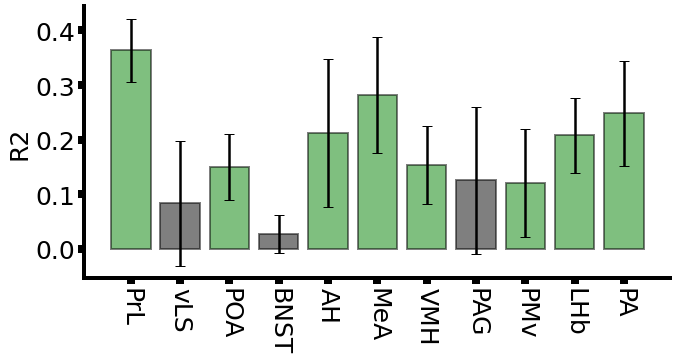

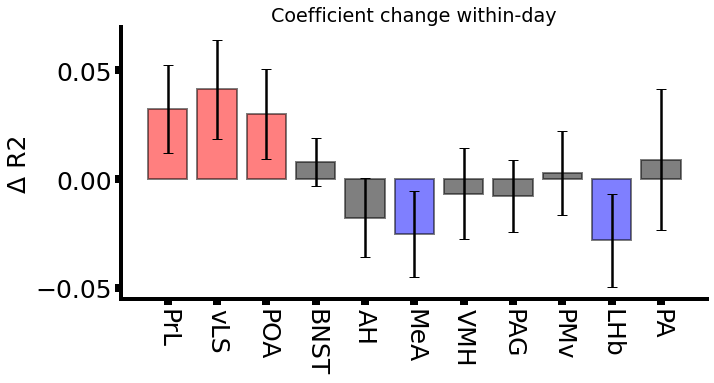

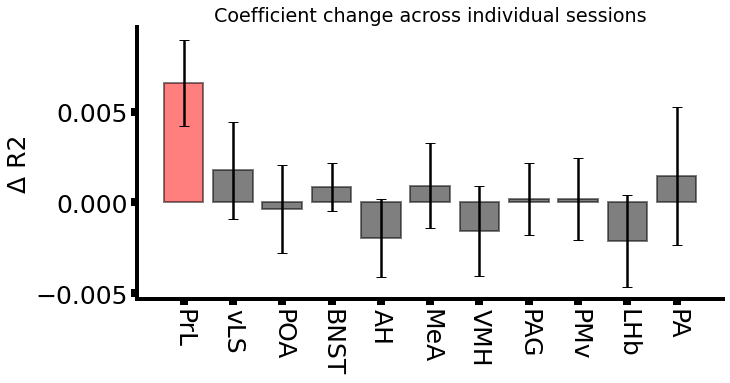

In [91]:
# Plotting

sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

# plotting intercept
plt.figure(figsize=(10.5, 5))
cond=0
intercept_pvals = []
for i, roi in enumerate(new_region_ids):
    # Extract result
    EI_result=all_roi_results[i].params['Intercept']
    pval=all_roi_results[i].pvalues[cond]
    intercept_pvals.append(pval)
    if EI_result > 0 and pval < 0.05:
        color='green'
    elif EI_result < 0 and pval < 0.05:
        color='blue'
    elif pval > 0.05:
        color='black'
    # Extract CI
    yerr=(all_roi_results[i].conf_int().iloc[cond, 1]-all_roi_results[i].conf_int().iloc[cond, 0]) * .5
        
    plt.bar(i, EI_result, color=color, alpha=0.5, edgecolor='black', linewidth=2, yerr=yerr, capsize=5)
# plt.ylim(top=0.25, bottom=-0.25)
plt.xticks(np.arange(len(new_region_ids)), new_region_ids, rotation=270)
plt.ylabel('R2')
sns.despine()

# plotting delta for session
plt.figure(figsize=(10.5, 5))
cond = 1
for i, roi in enumerate(new_region_ids):
    # Extract result
    EI_result=all_roi_results[i].params['session_trial']
    pval=all_roi_results[i].pvalues[cond]
    if EI_result > 0 and pval < 0.05:
        color='red'
    elif EI_result < 0 and pval < 0.05:
        color='blue'
    elif pval > 0.05:
        color='black'
    # Extract CI
    yerr=(all_roi_results[i].conf_int().iloc[cond, 1]-all_roi_results[i].conf_int().iloc[cond, 0]) * .5
        
    plt.bar(i, EI_result, color=color, alpha=0.5, edgecolor='black', linewidth=2, yerr=yerr, capsize=5)
# plt.ylim(top=0.006, bottom=-0.006)
plt.xticks(np.arange(len(new_region_ids)), new_region_ids, rotation=270)
plt.ylabel('Δ R2')
plt.title('Coefficient change within-day')
sns.despine()

# plotting delta for session
plt.figure(figsize=(10.5, 5))
cond = 2
cumul_pvalues = []
for i, roi in enumerate(new_region_ids):
    # Extract result
    EI_result=all_roi_results[i].params['cum_trial']
    pval=all_roi_results[i].pvalues[cond]
    cumul_pvalues.append(pval)
    if EI_result > 0 and pval < 0.05:
        color='red'
    elif EI_result < 0 and pval < 0.05:
        color='blue'
    elif pval > 0.05:
        color='black'
    # Extract CI
    yerr=(all_roi_results[i].conf_int().iloc[cond, 1]-all_roi_results[i].conf_int().iloc[cond, 0]) * .5
        
    plt.bar(i, EI_result, color=color, alpha=0.5, edgecolor='black', linewidth=2, yerr=yerr, capsize=5)
plt.xticks(np.arange(len(new_region_ids)), new_region_ids, rotation=270)
plt.ylabel('Δ R2')
plt.title('Coefficient change across individual sessions')
sns.despine()



In [92]:
import statsmodels.stats.multitest as multitest
np.set_printoptions(suppress=True, precision=10)
reject, corrected_p_values, _, _ = multitest.multipletests(cumul_pvalues, method='bonferroni')
print(corrected_p_values[ascending_idx])

[1.           1.           1.           1.           0.8280597268
 1.           1.           0.0000005914 1.           1.          ]


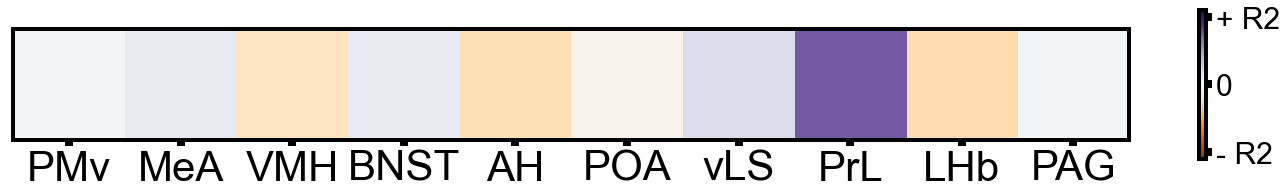

In [94]:
import matplotlib.colors as colors
import matplotlib.cm as cm

cumul_weights = np.asarray([all_roi_results[i].params['cum_trial'] for i in np.arange(10)])
# ascending_idx = np.argsort(cumul_weights)
cumul_weights = cumul_weights[ascending_idx]

cumul_pvalues = np.asarray([all_roi_results[i].pvalues[2] for i in np.arange(10)])
intercept_weights = np.asarray([all_roi_results[i].params['Intercept'] for i in np.arange(10)])
intercept_pvalues = np.asarray([all_roi_results[i].pvalues[0] for i in np.arange(10)])
data = np.hstack([intercept_weights.reshape(-1,1), cumul_weights.reshape(-1,1)])
p_values = np.hstack([intercept_pvalues.reshape(-1,1), cumul_pvalues.reshape(-1,1)])
# data[p_values > 0.05] = 0

cmap = cm.get_cmap("PuOr")
cmap_reversed = cmap.reversed()
norm = colors.TwoSlopeNorm(vmin=-0.01, vcenter=0, vmax=0.01)
plt.figure(figsize=(25, 5))  # Adjust the figure size to better fit the horizontal orientation
plt.imshow(data[:, 1].reshape(-1,1).T, cmap='PuOr', norm=norm)  # Transpose the data array
cbar=plt.colorbar(shrink=0.55, ticks=[-0.009, 0, 0.009], orientation='vertical')  # Make the colorbar horizontal
cbar.set_ticklabels(['- R2', 0, '+ R2'], fontfamily='Arial', fontsize=30)
plt.xticks(np.arange(10), np.array(new_region_ids)[ascending_idx], rotation=360, fontfamily='Arial', fontsize=42);  # Use xticks instead of yticks
plt.yticks([])  # Hide the yticks
# plt.gca().invert_yaxis()
plt.savefig('.\\retreat_figs\\non_R2_LMM.svg', dpi=600, bbox_inches='tight')

2. Whole trace regression (behavior agnostic) for ALL regions

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [41]:
agg_animal_scores = np.zeros((22, 27, len(agg_animals)))
agg_animal_weights = np.zeros((22, 22, 27, len(agg_animals)))
agg_animal_knockouts = agg_animal_weights.copy()
agg_animal_shuffled_scores = np.zeros((22, 10, 27, len(agg_animals)))
agg_animal_shuffled_weights = np.zeros((100, 22, 22, 27, len(agg_animals)))
agg_animal_shuffled_knockouts = agg_animal_shuffled_weights.copy()

for a, animal in enumerate(agg_animals):
    
    print('Processing data for %s' % animal)
    
    # load animal data
    trial_comps, rois = format4analysis(full_data, animal)
    rois = rois[:-3]
    norm_indices = [i for i, item in enumerate(region_ids) if item in set(rois)]
    trial_comps = np.concatenate(trial_comps, axis=2)
    
    # create arrays for storage of weights and % drop across epochs
    epoch_scores = np.zeros((trial_comps.shape[1], trial_comps.shape[2]))
    epoch_scores[:] = np.nan
    epoch_weights = np.zeros((trial_comps.shape[1], trial_comps.shape[1], trial_comps.shape[2]))
    epoch_weights[:] = np.nan
    epoch_knockouts = np.zeros((trial_comps.shape[1], trial_comps.shape[1], trial_comps.shape[2]))
    epoch_knockouts[:] = np.nan
#     epoch_shuffled_scores = np.zeros((trial_comps.shape[1], 10, trial_comps.shape[2]))
#     epoch_shuffled_scores[:] = np.nan
#     epoch_shuffled_weights = np.zeros((100, trial_comps.shape[1], trial_comps.shape[1], trial_comps.shape[2]))
#     epoch_shuffled_weights[:] = np.nan
#     epoch_shuffled_knockouts = epoch_shuffled_weights.copy()
#     epoch_shuffled_knockouts[:] = np.nan
    
    # containers for cross-validated score, weights and knockouts
    
    for e in np.arange(trial_comps.shape[-1]):
        print('Beginning epoch %i...' % e)
        epoch = trial_comps[:, :, e]
        for region_idx, orig_idx in enumerate(norm_indices):
            X, y = produce_XY(epoch, orig_idx)
            X_train, X_test, y_train, y_test, model, best_score = fit_ridge(X, y)
            model.fit(X, y)
            
            # save scores and such
            indices_without_region_idx = [x for x in norm_indices if orig_idx != x]
            epoch_weights[indices_without_region_idx, orig_idx, e] = model.coef_.flatten()
            if best_score<0:
                best_score=0
            epoch_scores[orig_idx, e] = best_score
            
            
            # perform region knockouts
            knockouts = np.zeros((X.shape[1]))
            for knockout_idx in np.arange(X.shape[1]):
                ko_model = deepcopy(model)
                new_coef=ko_model.coef_.copy()
                new_coef[:, knockout_idx] = 0.
                ko_model.coef_ = new_coef
                y_pred = ko_model.predict(X)
                ko_score = r2_score(y, y_pred)
                if ko_score < 0:
                    ko_score = 0
                knockout_score_difference = best_score - ko_score
                if knockout_score_difference < 0:
                    knockout_score_difference = 0
                knockouts[knockout_idx] = knockout_score_difference
            epoch_knockouts[indices_without_region_idx, orig_idx, e] = knockouts
        
    agg_animal_scores[:, :, a] = epoch_scores
    agg_animal_weights[:, :, :, a] = epoch_weights
    agg_animal_knockouts[:, :, :, a] = epoch_knockouts

Processing data for 3095
Beginning epoch 0...
Beginning epoch 1...
Beginning epoch 2...
Beginning epoch 3...
Beginning epoch 4...
Beginning epoch 5...
Beginning epoch 6...
Beginning epoch 7...
Beginning epoch 8...
Beginning epoch 9...
Beginning epoch 10...
Beginning epoch 11...
Beginning epoch 12...
Beginning epoch 13...
Beginning epoch 14...
Beginning epoch 15...
Beginning epoch 16...
Beginning epoch 17...
Beginning epoch 18...
Beginning epoch 19...
Beginning epoch 20...
Beginning epoch 21...
Beginning epoch 22...
Beginning epoch 23...
Beginning epoch 24...
Beginning epoch 25...
Beginning epoch 26...
Processing data for 3096
Beginning epoch 0...
Beginning epoch 1...
Beginning epoch 2...
Beginning epoch 3...
Beginning epoch 4...
Beginning epoch 5...
Beginning epoch 6...
Beginning epoch 7...
Beginning epoch 8...
Beginning epoch 9...
Beginning epoch 10...
Beginning epoch 11...
Beginning epoch 12...
Beginning epoch 13...
Beginning epoch 14...
Beginning epoch 15...
Beginning epoch 16...
Be

In [220]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from warnings import simplefilter
import warnings

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import DataConversionWarning, FitFailedWarning

# Ignore DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\Jorge\AppData\Local\Temp\ipykernel_27632\2605846097.py:5: RuntimeWarning: Mean of empty slice
  t =np.nanmean(agg_animal_weights, axis=-1)
posx and posy should be finite values


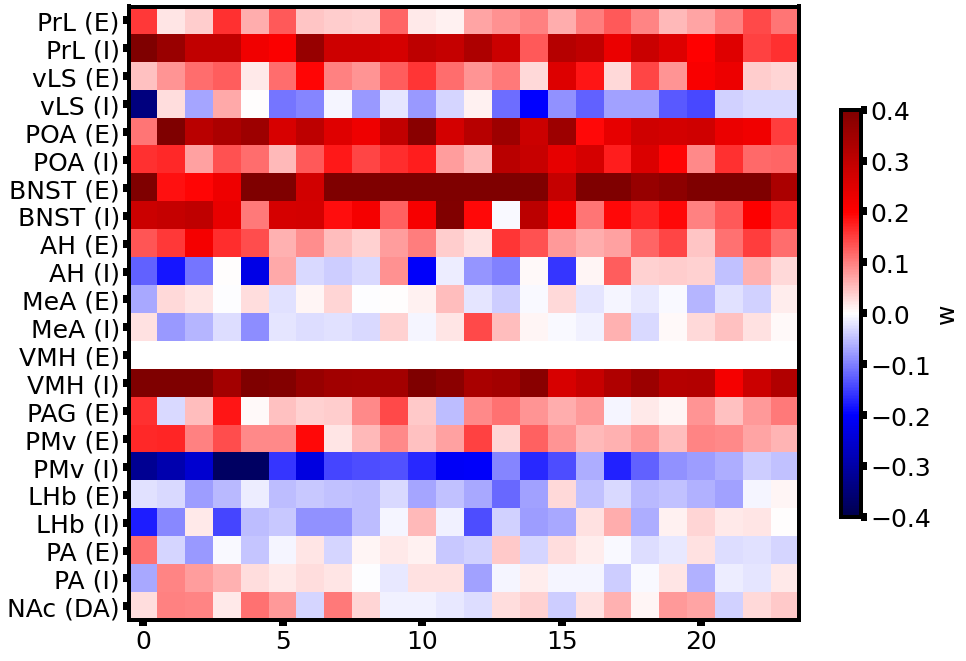

In [575]:
### weight plotting

import matplotlib.colors as mcolors
norm = mcolors.TwoSlopeNorm(vmin=-.4, vcenter=0, vmax=.4)
t =np.nanmean(agg_animal_weights, axis=-1)
plt.figure(figsize=(15, 15))
im=plt.imshow(t[:, 12, :-3], norm=norm, cmap='seismic')
plt.yticks(np.arange(22), region_ids);
colorbar = plt.colorbar(im, shrink=0.5)
colorbar.set_label('w')

C:\Users\Jorge\AppData\Local\Temp\ipykernel_27632\1492960041.py:4: RuntimeWarning: Mean of empty slice
  t =np.nanmean(agg_animal_knockouts, axis=-1)


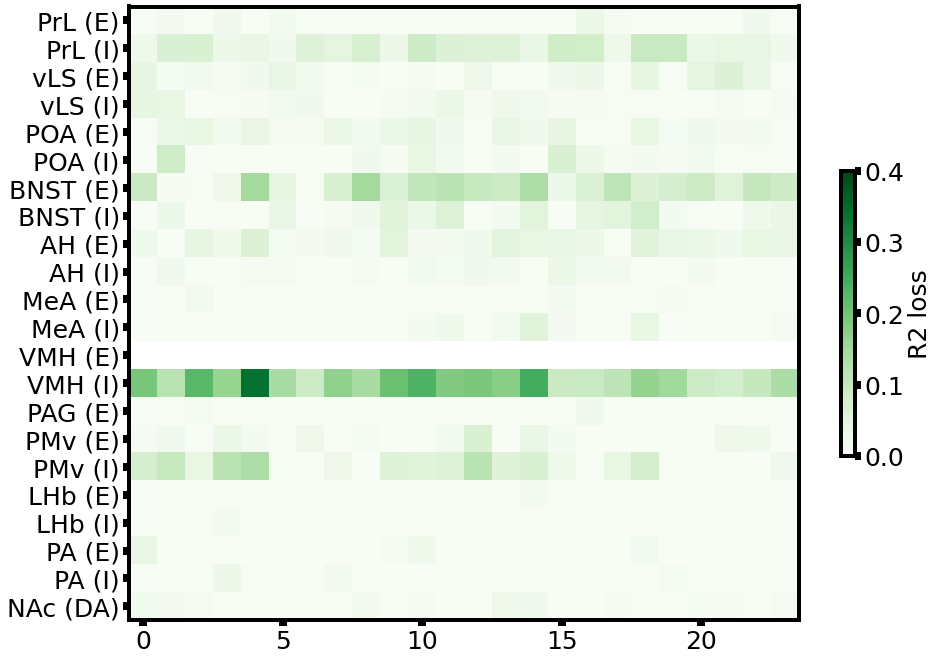

In [580]:
### weight plotting

import matplotlib.colors as mcolors
t =np.nanmean(agg_animal_knockouts, axis=-1)
plt.figure(figsize=(15, 15))
im=plt.imshow(t[:, 12, :-3], cmap='Greens', vmin=0, vmax=0.4)
plt.yticks(np.arange(22), region_ids);
colorbar = plt.colorbar(im, shrink=0.35)
colorbar.set_label('R2 loss')

In [584]:
# Fit LM model to each region / animal / session

region2quant = 'PMv (E)'
region_idx = indices[region2quant]
all_tables = {}
sessions2exclude = -3
weights2map = np.transpose(agg_animal_knockouts[:, region_idx, :sessions2exclude, :], [1, 0, 2])
total_sessions = 27 + sessions2exclude

for r, roi in enumerate(region_ids):

    r_vals = np.concatenate(weights2map[:, r, :].T)
    trials = np.hstack([np.arange(total_sessions) for i in np.arange(12)]).astype(int)
    days = np.hstack([np.hstack([np.repeat(i, 3) for i in np.arange((total_sessions)/3)]) for i in np.arange(12)]).astype(int)
    sessions =np.hstack([np.concatenate([np.hstack([np.arange(3) for i in np.arange(((total_sessions)/3))])]) for i in np.arange(12)]).astype(int)
    subjects = np.hstack([np.repeat(i, total_sessions) for i in np.arange(12)])
    table = pd.DataFrame(np.concatenate([trials.reshape(1,-1), days.reshape(1,-1), sessions.reshape(1,-1), subjects.reshape(1,-1), r_vals.reshape(1,-1)], axis=0).T)
    table = table.dropna(axis=0)
    all_tables[roi] = table
    
# do model fitting

def fit_model(df):
    results = {}
    # Create a mixed linear model using smf.mixedlm
    mixed_lm = smf.mixedlm(
        formula="dependent_variable ~ session_trial + cum_trial",
        groups="subject",
        data=df
    )

    # Fit the model
    mixed_lm_fit = mixed_lm.fit()

    # Print the summary of the model
    print(mixed_lm_fit.summary())
    
    return mixed_lm_fit

# run

new_region_ids = [x for x in region_ids if region2quant != x]
all_roi_results = []
for roi in new_region_ids:
    print(roi)
    sample = all_tables[roi]
    new_column_names = ['cum_trial', 'day_trial', 'session_trial', 'subject', 'dependent_variable']
    column_name_mapping = {old_column: new_column for old_column, new_column in zip(sample.columns, new_column_names)}
    sample = sample.rename(columns=column_name_mapping)
    sample = sample.reset_index(drop=True)
    sample = sample.dropna(axis=0)
    results = fit_model(sample)
    all_roi_results.append(results)

PrL (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     inf               
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
------------------------------------------------------------------
                   Coef.    Std.Err.   z   P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept           0.000                                         
session_trial       0.000                                         
cum_trial          -0.000                                         
subject Var         0.000                                         

PrL (I)
             Mixed Linear Model Regression Results
Model:            Mixe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in true_divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     750.2039          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -0.081  0.936  -0.001   0.001
session_trial     -0.000     0.000  -1.251  0.211  -0.001   0.000
cum_trial          0.000     0.000   1.991  0.047   0.000   0.000
subject Var        0.000     0.000                               

BNST (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.war

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0003            
Min. group size:  24      Log-Likelihood:     431.3905          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.003     0.003   0.999  0.318  -0.003   0.008
session_trial      0.002     0.002   1.084  0.278  -0.001   0.005
cum_trial         -0.000     0.000  -1.100  0.271  -0.001   0.000
subject Var        0.000     0.000                               

MeA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     801.6235          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.001   0.786  0.432  -0.001   0.001
session_trial      0.000     0.000   1.374  0.169  -0.000   0.001
cum_trial         -0.000     0.000  -1.377  0.169  -0.000   0.000
subject Var        0.000     0.000                               

PMv (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Ma

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1103.9535         
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -0.301  0.763  -0.000   0.000
session_trial     -0.000     0.000  -0.129  0.898  -0.000   0.000
cum_trial          0.000     0.000   1.090  0.276  -0.000   0.000
subject Var        0.000     0.000                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


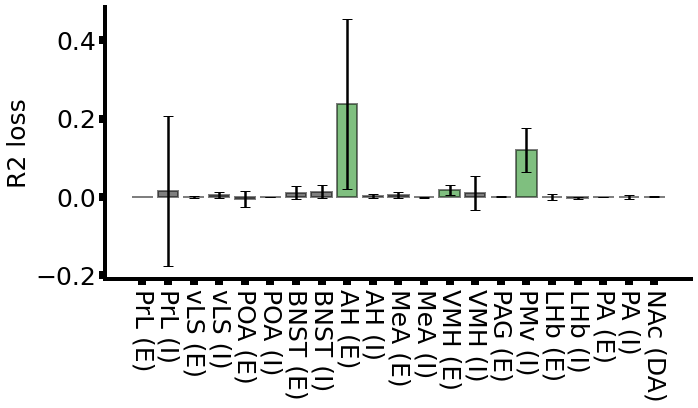

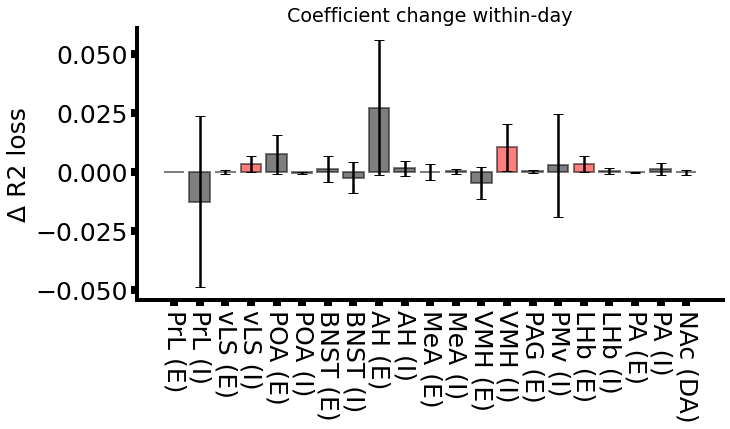

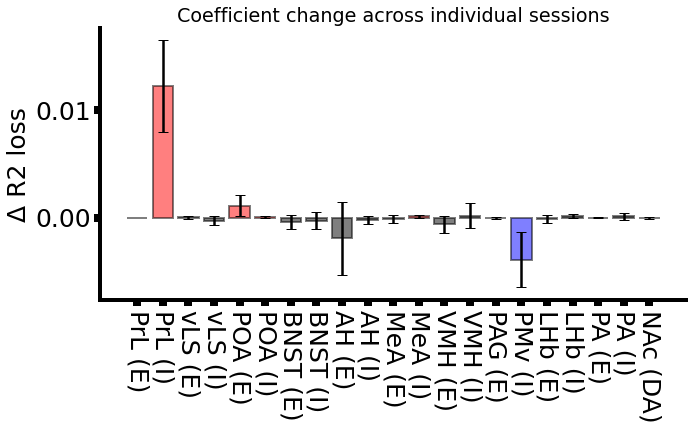

In [585]:
# Plotting

sns.set_context(rc={'lines.linewidth': 2.5,
                    'axes.labelsize': 25,
                    'axes.titlesize': 19.200000000000003,
                    'font.size': 25,
                    'xtick.major.width': 8,
                    'ytick.major.width': 8,
                    'xtick.major.size':6,
                    'ytick.major.size':6,
                    'axes.linewidth':4})

# plotting intercept
plt.figure(figsize=(10.5, 5))
cond=0
for i, roi in enumerate(new_region_ids):
    # Extract result
    EI_result=all_roi_results[i].params['Intercept']
    pval=all_roi_results[i].pvalues[cond]
    if EI_result > 0 and pval < 0.05:
        color='green'
    elif EI_result < 0 and pval < 0.05:
        color='blue'
    elif pval > 0.05:
        color='black'
    # Extract CI
    yerr=(all_roi_results[i].conf_int().iloc[cond, 1]-all_roi_results[i].conf_int().iloc[cond, 0]) * .5
        
    plt.bar(i, EI_result, color=color, alpha=0.5, edgecolor='black', linewidth=2, yerr=yerr, capsize=5)
# plt.ylim(top=0.25, bottom=-0.25)
plt.xticks(np.arange(len(new_region_ids)), new_region_ids, rotation=270)
plt.ylabel('R2 loss')
sns.despine()

# plotting delta for session
plt.figure(figsize=(10.5, 5))
cond = 1
for i, roi in enumerate(new_region_ids):
    # Extract result
    EI_result=all_roi_results[i].params['session_trial']
    pval=all_roi_results[i].pvalues[cond]
    if EI_result > 0 and pval < 0.05:
        color='red'
    elif EI_result < 0 and pval < 0.05:
        color='blue'
    elif pval > 0.05:
        color='black'
    # Extract CI
    yerr=(all_roi_results[i].conf_int().iloc[cond, 1]-all_roi_results[i].conf_int().iloc[cond, 0]) * .5
        
    plt.bar(i, EI_result, color=color, alpha=0.5, edgecolor='black', linewidth=2, yerr=yerr, capsize=5)
# plt.ylim(top=0.006, bottom=-0.006)
plt.xticks(np.arange(len(new_region_ids)), new_region_ids, rotation=270)
plt.ylabel('Δ R2 loss')
plt.title('Coefficient change within-day')
sns.despine()

# plotting delta for session
plt.figure(figsize=(10.5, 5))
cond = 2
for i, roi in enumerate(new_region_ids):
    # Extract result
    EI_result=all_roi_results[i].params['cum_trial']
    pval=all_roi_results[i].pvalues[cond]
    if EI_result > 0 and pval < 0.05:
        color='red'
    elif EI_result < 0 and pval < 0.05:
        color='blue'
    elif pval > 0.05:
        color='black'
    # Extract CI
    yerr=(all_roi_results[i].conf_int().iloc[cond, 1]-all_roi_results[i].conf_int().iloc[cond, 0]) * .5
        
    plt.bar(i, EI_result, color=color, alpha=0.5, edgecolor='black', linewidth=2, yerr=yerr, capsize=5)
plt.xticks(np.arange(len(new_region_ids)), new_region_ids, rotation=270)
plt.ylabel('Δ R2 loss')
plt.title('Coefficient change across individual sessions')
sns.despine()



Summary of encoding model results using knockout strategy

In [85]:
# putting everything together to get big matrix for each region with significance

intercept_matrix = np.zeros((22, 22))
intercept_matrix[:] = np.nan
intercept_pvals_matrix = intercept_matrix.copy()
cum_matrix = intercept_matrix.copy()
cum_pvals_matrix = intercept_matrix.copy()

for q, region2quant in enumerate(region_ids):
    print('Testing ', region2quant)
    region_idx = indices[region2quant]
    other_idxs = np.asarray([i for i, x in enumerate(region_ids) if region2quant !=x])
    all_tables = {}
    weights2map = np.transpose(agg_animal_knockouts[:, region_idx, :sessions2exclude, :], [1, 0, 2])
    
    # prep table
    for r, roi in enumerate(region_ids):

        r_vals = np.concatenate(weights2map[:, r, :].T)
        trials = np.hstack([np.arange(total_sessions) for i in np.arange(12)]).astype(int)
        days = np.hstack([np.hstack([np.repeat(i, 3) for i in np.arange((total_sessions)/3)]) for i in np.arange(12)]).astype(int)
        sessions =np.hstack([np.concatenate([np.hstack([np.arange(3) for i in np.arange(((total_sessions)/3))])]) for i in np.arange(12)]).astype(int)
        subjects = np.hstack([np.repeat(i, total_sessions) for i in np.arange(12)])
        table = pd.DataFrame(np.concatenate([trials.reshape(1,-1), days.reshape(1,-1), sessions.reshape(1,-1), subjects.reshape(1,-1), r_vals.reshape(1,-1)], axis=0).T)
        table = table.dropna(axis=0)
        all_tables[roi] = table
    new_region_ids = [x for x in region_ids if region2quant != x]
    all_roi_results = []
    
    # fit model
    for roi in new_region_ids:
        print(roi)
        sample = all_tables[roi]
        new_column_names = ['cum_trial', 'day_trial', 'session_trial', 'subject', 'dependent_variable']
        column_name_mapping = {old_column: new_column for old_column, new_column in zip(sample.columns, new_column_names)}
        sample = sample.rename(columns=column_name_mapping)
        sample = sample.reset_index(drop=True)
        sample = sample.dropna(axis=0)
        results = fit_model(sample)
        all_roi_results.append(results)
        
    # save results
    cond=0
    intercept_results = []
    intercept_pvals = []
    for i, roi in enumerate(new_region_ids):
        # Extract result
        EI_result=all_roi_results[i].params['Intercept']
        pval=all_roi_results[i].pvalues[cond]
        intercept_results.append(EI_result)
        intercept_pvals.append(pval)
    intercept_results = np.asarray(intercept_results)
    intercept_matrix[q, other_idxs] = intercept_results
    intercept_pvals = np.asarray(intercept_pvals)    
    intercept_pvals_matrix[q, other_idxs] = intercept_pvals
        
    cond = 2
    cum_pvals = []
    cum_results = []
    for i, roi in enumerate(new_region_ids):
        # Extract result
        EI_result=all_roi_results[i].params['cum_trial']
        cum_results.append(EI_result)
        pval=all_roi_results[i].pvalues[cond]
        cum_pvals.append(pval)
    cum_results = np.asarray(cum_results)
    cum_pvals = np.asarray(cum_pvals)
    cum_matrix[q, other_idxs] = cum_results
    cum_pvals_matrix[q, other_idxs] = cum_pvals
    

Testing  PrL (E)
PrL (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0278            
Min. group size:  24      Log-Likelihood:     71.3043           
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.409     0.053   7.723  0.000   0.305   0.513
session_trial      0.012     0.013   0.987  0.324  -0.012   0.037
cum_trial         -0.001     0.001  -0.380  0.704  -0.003   0.002
subject Var        0.025     0.072                               

vLS (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0014            
Min. group size:  24      Log-Likelihood:     478.7563          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.002     0.005   0.325  0.745  -0.008   0.012
session_trial      0.010     0.003   3.449  0.001   0.004   0.015
cum_trial         -0.000     0.000  -0.627  0.531  -0.001   0.000
subject Var        0.000     0.001                               

vLS (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in true_divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     665.8571          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.004     0.002   1.688  0.091  -0.001   0.008
session_trial      0.002     0.001   2.081  0.037   0.000   0.004
cum_trial         -0.000     0.000  -2.119  0.034  -0.001  -0.000
subject Var        0.000     0.000                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0017            
Min. group size:  24      Log-Likelihood:     407.8365          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.015     0.006   2.484  0.013   0.003   0.027
session_trial     -0.004     0.003  -1.360  0.174  -0.011   0.002
cum_trial         -0.000     0.000  -1.205  0.228  -0.001   0.000
subject Var        0.000     0.001                               

PAG (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     859.9631          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.000      0.000   0.032   0.974   -0.000    0.000
session_trial   0.000      0.000   0.714   0.475   -0.000    0.000
cum_trial       0.000      0.000   0.269   0.788   -0.000    0.000
subject Var     0.000      0.000                                  

PMv (I)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0007            
Min. group size:  24      Log-Likelihood:     353.0029          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.011     0.005   2.302  0.021   0.002   0.020
session_trial     -0.001     0.003  -0.527  0.598  -0.006   0.004
cum_trial         -0.001     0.000  -1.680  0.093  -0.001   0.000
subject Var        0.000     0.001                               

LHb (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


PrL (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0329            
Min. group size:  24      Log-Likelihood:     48.6350           
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.372      0.062   6.000   0.000    0.250    0.493
session_trial   0.039      0.014   2.843   0.004    0.012    0.066
cum_trial       0.001      0.002   0.876   0.381   -0.002    0.005
subject Var     0.036      0.093                                  

vLS (E)
             Mixed Linear Model Regression Results
Model:            Mixe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     622.6190          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.002  -0.194  0.846  -0.005   0.004
session_trial      0.002     0.001   2.057  0.040   0.000   0.004
cum_trial          0.000     0.000   0.220  0.826  -0.000   0.000
subject Var        0.000     0.001                               

BNST (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0005            
Min. group size:  24      Log-Likelihood:     561.4512          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.006     0.003   2.020  0.043   0.000   0.012
session_trial     -0.000     0.002  -0.017  0.986  -0.003   0.003
cum_trial         -0.000     0.000  -1.062  0.288  -0.001   0.000
subject Var        0.000     0.001                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.494

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     670.6677          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.002   0.458  0.647  -0.003   0.005
session_trial      0.002     0.001   1.844  0.065  -0.000   0.004
cum_trial         -0.000     0.000  -1.089  0.276  -0.000   0.000
subject Var        0.000     0.000                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     547.6612          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.002     0.001   1.660  0.097  -0.000   0.005
session_trial     -0.000     0.001  -0.143  0.887  -0.002   0.001
cum_trial         -0.000     0.000  -1.062  0.288  -0.000   0.000
subject Var        0.000     0.000                               

LHb (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     677.5120          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.004     0.002   2.072  0.038   0.000   0.008
session_trial      0.001     0.001   1.088  0.276  -0.001   0.003
cum_trial         -0.000     0.000  -1.949  0.051  -0.000   0.000
subject Var        0.000     0.000                               

Testing  vLS (E)
PrL (E)
             Mixed Linear Model Regression Results
Model:            Mi

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0022            
Min. group size:  24      Log-Likelihood:     369.9183          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.012     0.009   1.243  0.214  -0.007   0.030
session_trial      0.002     0.004   0.664  0.507  -0.005   0.010
cum_trial         -0.000     0.000  -0.135  0.893  -0.001   0.001
subject Var        0.000     0.005                               

BNST (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Ma

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1295.4300         
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -1.258  0.208  -0.001   0.000
session_trial      0.000     0.000   1.039  0.299  -0.000   0.000
cum_trial          0.000     0.000   1.547  0.122  -0.000   0.000
subject Var        0.000     0.000                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1333.0843         
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.000   0.000  1.000  -0.000   0.000
session_trial     -0.000     0.000  -0.077  0.939  -0.000   0.000
cum_trial          0.000     0.000   0.652  0.514  -0.000   0.000
subject Var        0.000     0.000                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     917.2259          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -1.041  0.298  -0.001   0.000
session_trial      0.000     0.000   1.426  0.154  -0.000   0.001
cum_trial          0.000     0.000   1.379  0.168  -0.000   0.000
subject Var        0.000     0.000                               

LHb (I)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.326795
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the bou

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0003            
Min. group size:  24      Log-Likelihood:     539.2527          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.003  -0.030  0.976  -0.005   0.005
session_trial      0.002     0.002   1.329  0.184  -0.001   0.005
cum_trial          0.000     0.000   1.024  0.306  -0.000   0.001
subject Var        0.000     0.000                               

PA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     798.9116          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.002   0.414  0.679  -0.002   0.004
session_trial     -0.000     0.001  -0.003  0.998  -0.002   0.002
cum_trial          0.000     0.000   0.888  0.374  -0.000   0.000
subject Var        0.000     0.000                               

PrL (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     904.9039          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -1.290  0.197  -0.001   0.000
session_trial      0.000     0.000   1.042  0.297  -0.000   0.001
cum_trial          0.000     0.000   1.536  0.124  -0.000   0.000
subject Var        0.000     0.000                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     912.6737          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -0.445  0.656  -0.001   0.001
session_trial      0.000     0.000   1.279  0.201  -0.000   0.001
cum_trial          0.000     0.000   1.257  0.209  -0.000   0.000
subject Var        0.000     0.000                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0025            
Min. group size:  24      Log-Likelihood:     352.8689          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.014      0.014   1.000   0.317   -0.014    0.042
session_trial   0.000      0.004   0.003   0.997   -0.008    0.008
cum_trial       0.001      0.000   1.744   0.081   -0.000    0.002
subject Var     0.001      0.015                                  

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0222            
Min. group size:  24      Log-Likelihood:     78.3007           
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.171      0.070   2.425   0.015    0.033    0.309
session_trial   0.016      0.013   1.274   0.203   -0.009    0.040
cum_trial       0.005      0.001   3.176   0.001    0.002    0.008
subject Var     0.040      0.141                                  

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Depen

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     882.7073          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.001   0.576  0.565  -0.001   0.001
session_trial      0.000     0.000   0.392  0.695  -0.000   0.001
cum_trial         -0.000     0.000  -0.307  0.759  -0.000   0.000
subject Var        0.000     0.000                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Ma

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0003            
Min. group size:  24      Log-Likelihood:     inf               
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
----------------------------------------------------------------
              Coef.  Std.Err.   z   P>|z|    [0.025     0.975]  
----------------------------------------------------------------
Intercept     0.000 51152.756 0.000 1.000 -100257.559 100257.559
session_trial 0.001     0.001 0.633 0.527      -0.002      0.003
cum_trial     0.000     0.000 0.868 0.385      -0.000      0.000
subject Var   0.000                                             

PAG (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     829.7327          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.000      0.000   0.085   0.932   -0.000    0.001
session_trial   0.000      0.000   0.908   0.364   -0.000    0.000
cum_trial       0.000      0.000   0.062   0.951   -0.000    0.000
subject Var     0.000      0.000                                  

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.war

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     639.2775          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.001  -0.109  0.913  -0.003   0.002
session_trial      0.001     0.001   1.395  0.163  -0.000   0.002
cum_trial          0.000     0.000   0.496  0.620  -0.000   0.000
subject Var        0.000     0.000                               

LHb (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0005            
Min. group size:  24      Log-Likelihood:     434.1724          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.003     0.004   0.877  0.380  -0.004   0.010
session_trial     -0.000     0.002  -0.149  0.882  -0.004   0.004
cum_trial          0.000     0.000   0.441  0.660  -0.000   0.001
subject Var        0.000     0.001                               

NAc (DA)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     894.6127          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.001     0.001  -1.265  0.206  -0.002   0.001
session_trial      0.001     0.000   1.481  0.139  -0.000   0.001
cum_trial          0.000     0.000   1.424  0.155  -0.000   0.000
subject Var        0.000     0.000                               

PrL (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0013            
Min. group size:  24      Log-Likelihood:     393.9686          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.016     0.007   2.317  0.020   0.002   0.029
session_trial      0.001     0.003   0.269  0.788  -0.005   0.007
cum_trial         -0.001     0.000  -1.703  0.089  -0.001   0.000
subject Var        0.000     0.003                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in true_divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     inf               
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
------------------------------------------------------------------
                   Coef.    Std.Err.   z   P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept           0.000                                         
session_trial       0.000                                         
cum_trial          -0.000                                         
subject Var         0.000                                         

PMv (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.757

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     514.7140          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.002     0.002  -0.916  0.360  -0.005   0.002
session_trial      0.001     0.001   1.002  0.316  -0.001   0.003
cum_trial          0.000     0.000   1.263  0.207  -0.000   0.000
subject Var        0.000     0.000                               

PMv (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0006            
Min. group size:  24      Log-Likelihood:     423.1800          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.002     0.004  -0.414  0.679  -0.009   0.006
session_trial     -0.002     0.002  -0.829  0.407  -0.006   0.002
cum_trial          0.001     0.000   2.064  0.039   0.000   0.001
subject Var        0.000     0.001                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0157            
Min. group size:  24      Log-Likelihood:     137.5171          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.066     0.026   2.522  0.012   0.015   0.118
session_trial      0.036     0.010   3.651  0.000   0.017   0.056
cum_trial         -0.002     0.001  -1.587  0.112  -0.004   0.000
subject Var        0.004     0.017                               

POA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0006            
Min. group size:  24      Log-Likelihood:     467.2526          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.005     0.004   1.069  0.285  -0.004   0.013
session_trial     -0.002     0.002  -0.925  0.355  -0.006   0.002
cum_trial          0.000     0.000   0.484  0.628  -0.000   0.001
subject Var        0.000     0.001                               

VMH (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     856.2927          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.001  -0.223  0.823  -0.001   0.001
session_trial     -0.000     0.000  -1.133  0.257  -0.001   0.000
cum_trial          0.000     0.000   1.877  0.061  -0.000   0.000
subject Var        0.000     0.000                               

LHb (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0013            
Min. group size:  24      Log-Likelihood:     390.1761          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.002     0.009  -0.185  0.853  -0.019   0.016
session_trial      0.007     0.003   2.432  0.015   0.001   0.013
cum_trial          0.000     0.000   1.382  0.167  -0.000   0.001
subject Var        0.000     0.007                               

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0039            
Min. group size:  24      Log-Likelihood:     264.5702          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.014      0.029   0.487   0.626   -0.043    0.071
session_trial   0.006      0.005   1.168   0.243   -0.004    0.016
cum_trial       0.002      0.001   2.762   0.006    0.000    0.003
subject Var     0.007      0.057                                  

MeA (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.330863
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1225.7586         
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.000   0.517  0.605  -0.000   0.000
session_trial      0.000     0.000   1.309  0.191  -0.000   0.000
cum_trial         -0.000     0.000  -0.947  0.343  -0.000   0.000
subject Var        0.000     0.000                               

MeA (I)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 5.066191
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the bou

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     744.6263          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.001     0.001  -1.171  0.242  -0.003   0.001
session_trial      0.001     0.001   1.988  0.047   0.000   0.002
cum_trial          0.000     0.000   1.659  0.097  -0.000   0.000
subject Var        0.000     0.000                               

VMH (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.771

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     801.8608          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.001   0.097  0.923  -0.001   0.001
session_trial     -0.000     0.000  -0.452  0.651  -0.001   0.000
cum_trial          0.000     0.000   1.036  0.300  -0.000   0.000
subject Var        0.000     0.000                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0111            
Min. group size:  24      Log-Likelihood:     136.5842          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.003     0.038  -0.079  0.937  -0.078   0.072
session_trial      0.005     0.009   0.481  0.631  -0.014   0.023
cum_trial          0.005     0.001   4.459  0.000   0.003   0.007
subject Var        0.009     0.051                               

NAc (DA)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0051            
Min. group size:  24      Log-Likelihood:     264.0812          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.010      0.029   0.358   0.720   -0.046    0.067
session_trial   0.008      0.006   1.421   0.155   -0.003    0.019
cum_trial       0.002      0.001   2.446   0.014    0.000    0.003
subject Var     0.007      0.051                                  

POA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0026            
Min. group size:  24      Log-Likelihood:     316.9693          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.024     0.009   2.692  0.007   0.007   0.042
session_trial      0.000     0.004   0.045  0.964  -0.008   0.009
cum_trial         -0.001     0.001  -1.805  0.071  -0.002   0.000
subject Var        0.000     0.003                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in true_divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  w

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     487.9025          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.003     0.002   1.377  0.168  -0.001   0.007
session_trial      0.000     0.001   0.355  0.722  -0.002   0.003
cum_trial         -0.000     0.000  -0.443  0.658  -0.000   0.000
subject Var        0.000     0.000                               

LHb (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in true_divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users

 AH (I)
PrL (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     740.4543          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.003     0.002   1.776  0.076  -0.000   0.006
session_trial      0.001     0.001   0.887  0.375  -0.001   0.002
cum_trial         -0.000     0.000  -1.621  0.105  -0.000   0.000
subject Var        0.000     0.000                               

PrL (I)
             Mixed Linear Model Regression Results
Model:            Mix

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0004            
Min. group size:  24      Log-Likelihood:     591.0277          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.004     0.003   1.612  0.107  -0.001   0.010
session_trial     -0.000     0.002  -0.067  0.947  -0.003   0.003
cum_trial          0.000     0.000   0.108  0.914  -0.000   0.000
subject Var        0.000     0.000                               

vLS (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     594.3816          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.003     0.002   1.321  0.187  -0.001   0.007
session_trial      0.001     0.001   1.195  0.232  -0.001   0.004
cum_trial         -0.000     0.000  -1.094  0.274  -0.000   0.000
subject Var        0.000     0.000                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Ma

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0016            
Min. group size:  24      Log-Likelihood:     376.7454          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.008     0.006   1.270  0.204  -0.004   0.019
session_trial      0.002     0.003   0.731  0.465  -0.004   0.009
cum_trial         -0.000     0.000  -1.080  0.280  -0.001   0.000
subject Var        0.000     0.001                               

VMH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.748684
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the bou

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     473.3835          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.004     0.002   1.670  0.095  -0.001   0.008
session_trial     -0.001     0.001  -0.557  0.577  -0.003   0.002
cum_trial         -0.000     0.000  -1.013  0.311  -0.000   0.000
subject Var        0.000     0.000                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1426.4503         
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -0.302  0.763  -0.000   0.000
session_trial     -0.000     0.000  -0.128  0.898  -0.000   0.000
cum_trial          0.000     0.000   1.089  0.276  -0.000   0.000
subject Var        0.000     0.000                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     816.9641          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.001   1.486  0.137  -0.000   0.003
session_trial     -0.000     0.000  -0.180  0.857  -0.001   0.001
cum_trial         -0.000     0.000  -0.667  0.505  -0.000   0.000
subject Var        0.000     0.000                               

Testing  MeA (E)
PrL (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     789.3728          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.001     0.001  -0.687  0.492  -0.003   0.002
session_trial      0.001     0.001   1.178  0.239  -0.001   0.002
cum_trial          0.000     0.000   0.662  0.508  -0.000   0.000
subject Var        0.000     0.000                               

PrL (I)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0008            
Min. group size:  24      Log-Likelihood:     498.2679          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.003     0.004   0.638  0.524  -0.005   0.011
session_trial      0.003     0.002   1.503  0.133  -0.001   0.008
cum_trial         -0.000     0.000  -0.573  0.567  -0.001   0.000
subject Var        0.000     0.001                               

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     712.8182          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.001     0.001  -0.839  0.401  -0.003   0.001
session_trial      0.001     0.001   1.103  0.270  -0.001   0.002
cum_trial          0.000     0.000   0.961  0.337  -0.000   0.000
subject Var        0.000     0.000                               

POA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     614.6739          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.004     0.002   1.606  0.108  -0.001   0.008
session_trial      0.001     0.001   1.189  0.234  -0.001   0.003
cum_trial         -0.000     0.000  -2.049  0.041  -0.000  -0.000
subject Var        0.000     0.001                               

BNST (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.war

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     790.9903          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.002  -0.101  0.919  -0.003   0.003
session_trial      0.001     0.001   1.340  0.180  -0.001   0.003
cum_trial          0.000     0.000   0.784  0.433  -0.000   0.000
subject Var        0.000     0.000                               

VMH (I)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.891

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0005            
Min. group size:  24      Log-Likelihood:     613.8582          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.006     0.003   1.854  0.064  -0.000   0.012
session_trial      0.001     0.002   0.795  0.426  -0.002   0.005
cum_trial         -0.000     0.000  -1.131  0.258  -0.001   0.000
subject Var        0.000     0.000                               

PAG (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     908.2262          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.000   0.835  0.404  -0.000   0.001
session_trial      0.000     0.000   1.404  0.160  -0.000   0.001
cum_trial         -0.000     0.000  -1.536  0.124  -0.000   0.000
subject Var        0.000     0.000                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     881.3348          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.000   1.296  0.195  -0.000   0.001
session_trial      0.000     0.000   1.851  0.064  -0.000   0.001
cum_trial         -0.000     0.000  -1.951  0.051  -0.000   0.000
subject Var        0.000     0.000                               

LHb (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization w

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1087.5641         
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.000   1.670  0.095  -0.000   0.001
session_trial      0.000     0.000   0.675  0.499  -0.000   0.000
cum_trial         -0.000     0.000  -1.928  0.054  -0.000   0.000
subject Var        0.000     0.000                               

Testing  MeA (I)
PrL (E)
             Mixed Linear Model Regression Results
Model:            Mi

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0003            
Min. group size:  24      Log-Likelihood:     541.1524          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.000      0.003   0.042   0.967   -0.005    0.006
session_trial   0.001      0.002   0.520   0.603   -0.002    0.004
cum_trial       0.000      0.000   0.967   0.333   -0.000    0.001
subject Var     0.000      0.000                                  

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Depen

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0027            
Min. group size:  24      Log-Likelihood:     272.4631          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.011     0.014  -0.759  0.448  -0.039   0.017
session_trial      0.007     0.005   1.508  0.132  -0.002   0.016
cum_trial          0.001     0.001   2.664  0.008   0.000   0.003
subject Var        0.001     0.013                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0197            
Min. group size:  24      Log-Likelihood:     96.7179           
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.137     0.036   3.812  0.000   0.067   0.208
session_trial     -0.006     0.012  -0.503  0.615  -0.029   0.017
cum_trial         -0.000     0.001  -0.299  0.765  -0.003   0.002
subject Var        0.008     0.031                               

NAc (DA)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1099.6595         
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.000   0.540  0.589  -0.000   0.001
session_trial      0.000     0.000   2.032  0.042   0.000   0.001
cum_trial         -0.000     0.000  -1.297  0.195  -0.000   0.000
subject Var        0.000     0.000                               

Testing  VMH (E)
PrL (E)
             Mixed Linear Model Regression Results
Model:            Mi

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0019            
Min. group size:  24      Log-Likelihood:     427.8093          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.020     0.009   2.198  0.028   0.002   0.038
session_trial     -0.000     0.003  -0.069  0.945  -0.007   0.006
cum_trial         -0.001     0.000  -2.130  0.033  -0.002  -0.000
subject Var        0.001     0.006                               

POA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     567.3915          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.001      0.002   0.343   0.732   -0.003    0.004
session_trial   0.000      0.001   0.407   0.684   -0.002    0.002
cum_trial       0.000      0.000   0.034   0.973   -0.000    0.000
subject Var     0.000      0.000                                  

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.wa

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     707.4925          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.001  -0.377  0.706  -0.002   0.001
session_trial      0.001     0.000   1.190  0.234  -0.000   0.002
cum_trial          0.000     0.000   0.218  0.827  -0.000   0.000
subject Var        0.000     0.000                               

LHb (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0007            
Min. group size:  24      Log-Likelihood:     457.3763          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.010     0.005   2.074  0.038   0.001   0.019
session_trial     -0.003     0.002  -1.413  0.158  -0.007   0.001
cum_trial         -0.000     0.000  -1.078  0.281  -0.001   0.000
subject Var        0.000     0.002                               

PA (I)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.576231
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     580.6216          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.005     0.002   2.398  0.016   0.001   0.010
session_trial     -0.001     0.001  -0.923  0.356  -0.004   0.001
cum_trial         -0.000     0.000  -1.239  0.215  -0.000   0.000
subject Var        0.000     0.000                               

NAc (DA)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.573857
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0005            
Min. group size:  24      Log-Likelihood:     546.5199          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.003     0.004   0.908  0.364  -0.004   0.011
session_trial      0.002     0.002   1.158  0.247  -0.001   0.006
cum_trial         -0.000     0.000  -0.391  0.696  -0.001   0.000
subject Var        0.000     0.001                               

Testing  VMH (I)
PrL (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.714

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1193.5023         
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -0.881  0.378  -0.001   0.000
session_trial      0.000     0.000   0.785  0.432  -0.000   0.000
cum_trial          0.000     0.000   1.541  0.123  -0.000   0.000
subject Var        0.000     0.000                               

PrL (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     956.5983          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -1.209  0.227  -0.001   0.000
session_trial      0.000     0.000   0.681  0.496  -0.000   0.001
cum_trial          0.000     0.000   2.321  0.020   0.000   0.000
subject Var        0.000     0.000                               

POA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.war

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     617.0690          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.001     0.002  -0.318  0.750  -0.004   0.003
session_trial      0.002     0.001   1.799  0.072  -0.000   0.004
cum_trial          0.000     0.000   0.983  0.326  -0.000   0.000
subject Var        0.000     0.000                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1022.4975         
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.001  -0.593  0.553  -0.002   0.001
session_trial      0.000     0.000   0.794  0.427  -0.000   0.001
cum_trial          0.000     0.000   1.309  0.191  -0.000   0.000
subject Var        0.000     0.000                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     785.5894          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.001  -0.354  0.723  -0.001   0.001
session_trial      0.000     0.000   0.677  0.498  -0.000   0.001
cum_trial          0.000     0.000   0.849  0.396  -0.000   0.000
subject Var        0.000     0.000                               

LHb (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0004            
Min. group size:  24      Log-Likelihood:     398.9042          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.003      0.004   0.708   0.479   -0.005    0.010
session_trial   0.003      0.002   1.401   0.161   -0.001    0.006
cum_trial       0.000      0.000   0.353   0.724   -0.000    0.001
subject Var     0.000      0.001                                  

PrL (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     442.5615          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.005     0.003   1.700  0.089  -0.001   0.010
session_trial     -0.002     0.001  -1.043  0.297  -0.004   0.001
cum_trial         -0.000     0.000  -0.167  0.867  -0.000   0.000
subject Var        0.000     0.001                               

POA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in true_divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warning

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0003            
Min. group size:  24      Log-Likelihood:     502.8537          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.003     0.003   0.982  0.326  -0.003   0.008
session_trial     -0.000     0.001  -0.310  0.757  -0.003   0.002
cum_trial          0.000     0.000   0.736  0.462  -0.000   0.000
subject Var        0.000     0.001                               

VMH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     662.9706          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.002     0.001  -1.590  0.112  -0.004   0.000
session_trial      0.001     0.001   1.620  0.105  -0.000   0.002
cum_trial          0.000     0.000   1.975  0.048   0.000   0.000
subject Var        0.000     0.000                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = nan
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2005: RuntimeWarning: divide by zero encountered in true

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     695.7275          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.000      0.001   0.441   0.659   -0.001    0.002
session_trial   0.000      0.001   0.209   0.835   -0.001    0.001
cum_trial       0.000      0.000   0.226   0.821   -0.000    0.000
subject Var     0.000      0.000                                  

vLS (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.war

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0003            
Min. group size:  24      Log-Likelihood:     431.3905          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.003     0.003   0.999  0.318  -0.003   0.008
session_trial      0.002     0.002   1.084  0.278  -0.001   0.005
cum_trial         -0.000     0.000  -1.100  0.271  -0.001   0.000
subject Var        0.000     0.000                               

MeA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.war

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     801.6235          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.001   0.786  0.432  -0.001   0.001
session_trial      0.000     0.000   1.374  0.169  -0.000   0.001
cum_trial         -0.000     0.000  -1.377  0.169  -0.000   0.000
subject Var        0.000     0.000                               

PMv (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1103.9535         
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -0.301  0.763  -0.000   0.000
session_trial     -0.000     0.000  -0.129  0.898  -0.000   0.000
cum_trial          0.000     0.000   1.090  0.276  -0.000   0.000
subject Var        0.000     0.000                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.wa

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     683.0535          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.001   0.910  0.363  -0.001   0.003
session_trial      0.000     0.001   0.078  0.938  -0.001   0.001
cum_trial         -0.000     0.000  -0.659  0.510  -0.000   0.000
subject Var        0.000     0.000                               

Testing  PMv (I)
PrL (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.107

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     776.7498          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.000   0.602  0.547  -0.000   0.001
session_trial      0.000     0.000   0.026  0.980  -0.000   0.000
cum_trial         -0.000     0.000  -0.217  0.828  -0.000   0.000
subject Var        0.000     0.000                               

PrL (I)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     667.1184          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.000      0.001   0.338   0.735   -0.001    0.002
session_trial   0.000      0.000   0.291   0.771   -0.001    0.001
cum_trial       0.000      0.000   0.446   0.655   -0.000    0.000
subject Var     0.000      0.000                                  

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0043            
Min. group size:  24      Log-Likelihood:     231.5192          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.050     0.014   3.569  0.000   0.023   0.078
session_trial     -0.005     0.006  -0.815  0.415  -0.016   0.007
cum_trial         -0.002     0.001  -3.298  0.001  -0.004  -0.001
subject Var        0.001     0.008                               

AH (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0004            
Min. group size:  24      Log-Likelihood:     404.3068          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.002     0.003   0.741  0.459  -0.004   0.009
session_trial     -0.001     0.002  -0.499  0.618  -0.005   0.003
cum_trial          0.000     0.000   0.469  0.639  -0.000   0.001
subject Var        0.000     0.001                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0007            
Min. group size:  24      Log-Likelihood:     403.7930          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.009     0.005   2.021  0.043   0.000   0.019
session_trial      0.000     0.002   0.203  0.839  -0.004   0.005
cum_trial         -0.001     0.000  -2.067  0.039  -0.001  -0.000
subject Var        0.000     0.001                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in true_divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  w

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     647.2778          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.001   0.938  0.348  -0.001   0.004
session_trial     -0.000     0.001  -0.115  0.909  -0.001   0.001
cum_trial          0.000     0.000   0.191  0.848  -0.000   0.000
subject Var        0.000     0.000                               

Testing  LHb (E)
PrL (E)
             Mixed Linear Model Regression Results
Model:            Mi

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0019            
Min. group size:  24      Log-Likelihood:     304.5113          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.011     0.013   0.836  0.403  -0.015   0.037
session_trial     -0.001     0.004  -0.295  0.768  -0.009   0.006
cum_trial          0.000     0.000   1.004  0.316  -0.000   0.001
subject Var        0.001     0.014                               

BNST (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization w

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     690.7604          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.001   1.186  0.236  -0.001   0.003
session_trial      0.001     0.001   1.111  0.266  -0.000   0.002
cum_trial         -0.000     0.000  -1.445  0.149  -0.000   0.000
subject Var        0.000     0.000                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0013            
Min. group size:  24      Log-Likelihood:     352.4617          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.006   0.203  0.839  -0.010   0.013
session_trial     -0.001     0.003  -0.203  0.839  -0.007   0.006
cum_trial          0.001     0.000   1.420  0.156  -0.000   0.001
subject Var        0.000     0.001                               

LHb (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     523.0576          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.002   0.309  0.757  -0.004   0.005
session_trial     -0.000     0.001  -0.287  0.774  -0.003   0.002
cum_trial          0.000     0.000   0.500  0.617  -0.000   0.000
subject Var        0.000     0.000                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization w

              Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: dependent_variable
No. Observations:   216     Method:             REML              
No. Groups:         9       Scale:              0.0009            
Min. group size:    24      Log-Likelihood:     inf               
Max. group size:    24      Converged:          Yes               
Mean group size:    24.0                                          
------------------------------------------------------------------
              Coef.   Std.Err.   z    P>|z|    [0.025     0.975]  
------------------------------------------------------------------
Intercept      0.000 99038.289  0.000 1.000 -194111.479 194111.479
session_trial  0.005     0.003  1.805 0.071      -0.000      0.010
cum_trial     -0.000     0.000 -0.669 0.504      -0.001      0.000
subject Var    0.000                                              

vLS (I)
             Mixed Linear Model Regression Results
Model:           

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.277689
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the bou

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     897.3949          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.000   0.893  0.372  -0.000   0.001
session_trial      0.000     0.000   1.256  0.209  -0.000   0.001
cum_trial         -0.000     0.000  -1.323  0.186  -0.000   0.000
subject Var        0.000     0.000                               

POA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0002            
Min. group size:  24      Log-Likelihood:     545.7793          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.006     0.002   3.153  0.002   0.002   0.010
session_trial     -0.000     0.001  -0.302  0.762  -0.003   0.002
cum_trial         -0.000     0.000  -2.129  0.033  -0.001  -0.000
subject Var        0.000     0.000                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0013            
Min. group size:  24      Log-Likelihood:     339.1579          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.010     0.014   0.692  0.489  -0.018   0.037
session_trial      0.008     0.003   2.393  0.017   0.001   0.014
cum_trial         -0.000     0.000  -0.040  0.968  -0.001   0.001
subject Var        0.001     0.020                               

VMH (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.367

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     941.5040          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.000     0.000  -0.372  0.710  -0.001   0.000
session_trial      0.000     0.000   0.342  0.733  -0.000   0.000
cum_trial          0.000     0.000   1.021  0.307  -0.000   0.000
subject Var        0.000     0.000                               

PMv (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0008            
Min. group size:  24      Log-Likelihood:     395.0593          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.005     0.005   0.942  0.346  -0.006   0.016
session_trial      0.002     0.002   0.741  0.458  -0.003   0.007
cum_trial         -0.000     0.000  -0.593  0.553  -0.001   0.000
subject Var        0.000     0.003                               

PMv (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     664.8862          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.001   0.452  0.651  -0.002   0.003
session_trial     -0.001     0.001  -1.441  0.150  -0.002   0.000
cum_trial          0.000     0.000   1.109  0.268  -0.000   0.000
subject Var        0.000     0.000                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.war

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0004            
Min. group size:  24      Log-Likelihood:     461.6877          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.000      0.003   0.141   0.888   -0.006    0.007
session_trial   0.001      0.002   0.429   0.668   -0.003    0.004
cum_trial       0.000      0.000   1.762   0.078   -0.000    0.001
subject Var     0.000      0.000                                  

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0143            
Min. group size:  24      Log-Likelihood:     112.4057          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.095      0.048   2.002   0.045    0.002    0.189
session_trial   0.014      0.011   1.288   0.198   -0.007    0.035
cum_trial       0.001      0.001   0.993   0.321   -0.001    0.004
subject Var     0.015      0.072                                  

BNST (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dep

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     604.5655          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.001   0.619  0.536  -0.001   0.003
session_trial     -0.001     0.001  -1.180  0.238  -0.002   0.000
cum_trial          0.000     0.000   0.974  0.330  -0.000   0.000
subject Var        0.000     0.000                               

AH (I)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.339344
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the bou

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     628.9899          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.001   0.110  0.912  -0.002   0.002
session_trial      0.001     0.000   1.362  0.173  -0.000   0.002
cum_trial         -0.000     0.000  -0.371  0.710  -0.000   0.000
subject Var        0.000     0.000                               

MeA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     788.5976          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.001   2.185  0.029   0.000   0.002
session_trial     -0.000     0.000  -1.028  0.304  -0.001   0.000
cum_trial         -0.000     0.000  -1.516  0.130  -0.000   0.000
subject Var        0.000     0.000                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     1225.0297         
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.000     0.000   0.300  0.764  -0.000   0.000
session_trial     -0.000     0.000  -0.026  0.980  -0.000   0.000
cum_trial          0.000     0.000   0.217  0.828  -0.000   0.000
subject Var        0.000     0.000                               

LHb (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     943.1259          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.000   2.211  0.027   0.000   0.002
session_trial     -0.000     0.000  -1.041  0.298  -0.001   0.000
cum_trial         -0.000     0.000  -1.542  0.123  -0.000   0.000
subject Var        0.000     0.000                               

Testing  PA (I)
PrL (E)
             Mixed Linear Model Regression Results
Model:            Mix

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0023            
Min. group size:  24      Log-Likelihood:     284.3319          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.002     0.017  -0.107  0.915  -0.034   0.031
session_trial      0.002     0.004   0.430  0.667  -0.007   0.010
cum_trial          0.001     0.001   2.698  0.007   0.000   0.002
subject Var        0.002     0.021                               

BNST (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     486.4575          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.002     0.002  -0.854  0.393  -0.006   0.002
session_trial      0.001     0.001   1.038  0.299  -0.001   0.003
cum_trial          0.000     0.000   1.315  0.188  -0.000   0.000
subject Var        0.000     0.000                               

AH (I)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 1.563172
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to con

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     502.0753          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.003     0.002   1.402  0.161  -0.001   0.006
session_trial     -0.000     0.001  -0.058  0.954  -0.002   0.002
cum_trial         -0.000     0.000  -0.584  0.560  -0.000   0.000
subject Var        0.000     0.000                               

MeA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     773.4642          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.001   1.282  0.200  -0.000   0.002
session_trial     -0.000     0.000  -1.190  0.234  -0.001   0.000
cum_trial         -0.000     0.000  -0.218  0.827  -0.000   0.000
subject Var        0.000     0.000                               

LHb (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1556: RuntimeWarning: divide by zero encountered in log
  likeval -= (self.n_totobs - self.k_fe) * np.log(qf) / 2.
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1796: RuntimeWarning: invalid value encountered in true_divide
  score_re += 0.5 * fac * rvavr[0:self.k_re2] / rvir
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2098: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
C:\Users

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0018            
Min. group size:  24      Log-Likelihood:     394.7329          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.014     0.008   1.617  0.106  -0.003   0.030
session_trial      0.006     0.003   1.848  0.065  -0.000   0.013
cum_trial         -0.000     0.000  -0.823  0.411  -0.001   0.000
subject Var        0.000     0.005                               

PrL (I)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0015            
Min. group size:  24      Log-Likelihood:     416.9553          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.015     0.006   2.323  0.020   0.002   0.028
session_trial     -0.003     0.003  -0.968  0.333  -0.009   0.003
cum_trial         -0.000     0.000  -0.266  0.790  -0.001   0.001
subject Var        0.000     0.002                               

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0082            
Min. group size:  24      Log-Likelihood:     190.7556          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.028      0.022   1.258   0.209   -0.016    0.072
session_trial   0.013      0.008   1.711   0.087   -0.002    0.028
cum_trial       0.000      0.001   0.428   0.669   -0.001    0.002
subject Var     0.003      0.018                                  

AH (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Depen

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0001            
Min. group size:  24      Log-Likelihood:     787.0073          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept         -0.001     0.001  -0.549  0.583  -0.003   0.002
session_trial      0.001     0.001   1.728  0.084  -0.000   0.002
cum_trial          0.000     0.000   0.378  0.706  -0.000   0.000
subject Var        0.000     0.000                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0000            
Min. group size:  24      Log-Likelihood:     668.2120          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.001     0.001   0.828  0.408  -0.001   0.003
session_trial      0.000     0.001   0.707  0.480  -0.001   0.002
cum_trial         -0.000     0.000  -0.863  0.388  -0.000   0.000
subject Var        0.000     0.000                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.wa

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0004            
Min. group size:  24      Log-Likelihood:     521.6055          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.002     0.003   0.721  0.471  -0.004   0.008
session_trial      0.003     0.002   1.552  0.121  -0.001   0.006
cum_trial         -0.000     0.000  -1.050  0.294  -0.001   0.000
subject Var        0.000     0.001                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 2.860

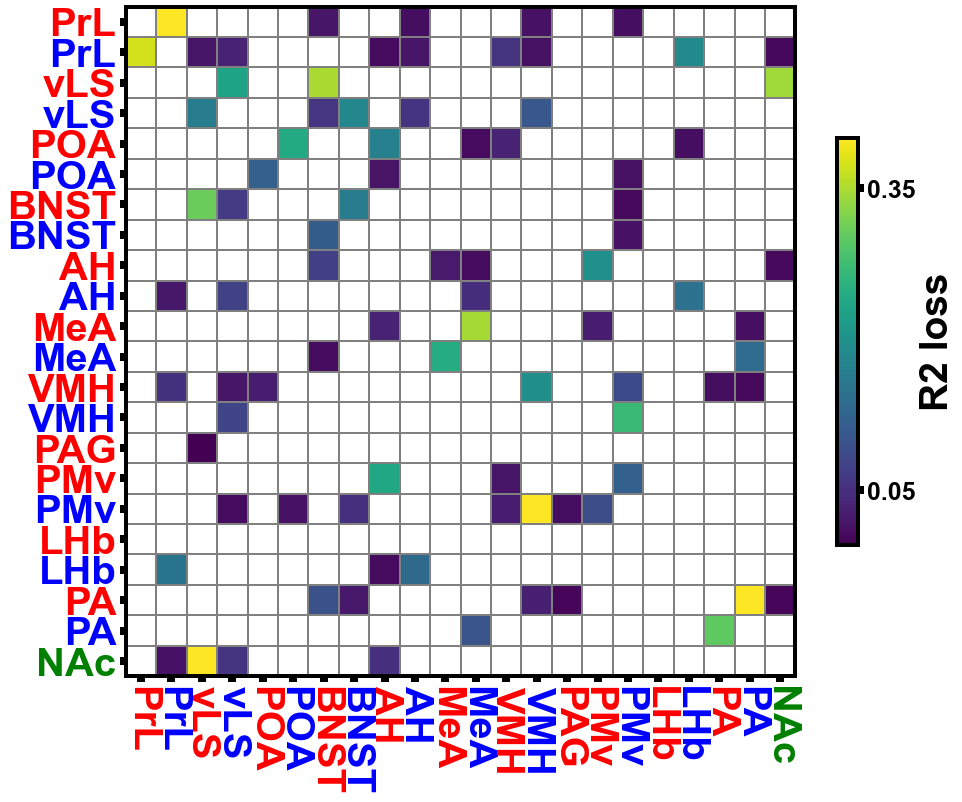

In [86]:
# Create a mask for p-values less than 0.05
mask = intercept_pvals_matrix < 0.05

# Set the masked regions to NaN in the magnitude matrix
intercept_matrix_mask = intercept_matrix.copy()
intercept_matrix_mask[~mask] = np.nan

# Regular plotting with p-value color coding
plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('viridis')  # You can change the colormap as needed
im = plt.imshow(intercept_matrix_mask, cmap=cmap, vmax=0.4, interpolation='nearest')
# plt.grid(True, color='black', linewidth=5)
plt.xticks(np.arange(22), np.array([x.split(' ')[0] for x in region_ids]), rotation=270, weight='bold', fontfamily='Arial', fontsize=40);
plt.yticks(np.arange(22), np.array([x.split(' ')[0] for x in region_ids]), weight='bold', fontfamily='Arial', fontsize=40);
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label("R2 loss", fontfamily='Arial', fontsize=39, weight='bold')
cbar.set_ticks([0.05, 0.35])
cbar.set_ticklabels([0.05, 0.35], fontfamily='Arial', fontsize=25, weight='bold')

# Minor ticks
ax = plt.gca();
ax.set_xticks(np.arange(-.5, 22, 1), minor=True)
ax.set_yticks(np.arange(-.5, 22, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='gray', linestyle='-', linewidth=2)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

# Get the current y tick labels
ytick_labels = plt.gca().yaxis.get_ticklabels()
xtick_labels = plt.gca().xaxis.get_ticklabels()

# Define colors for each y tick label
colorcode = ['red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'green']
# Iterate through y tick labels and set their colors
for ylabel, xlabel, color in zip(ytick_labels, xtick_labels, colorcode):
    ylabel.set_color(color)
    xlabel.set_color(color)
plt.savefig('R2_loss_intercept.png', dpi=600, bbox_inches='tight')

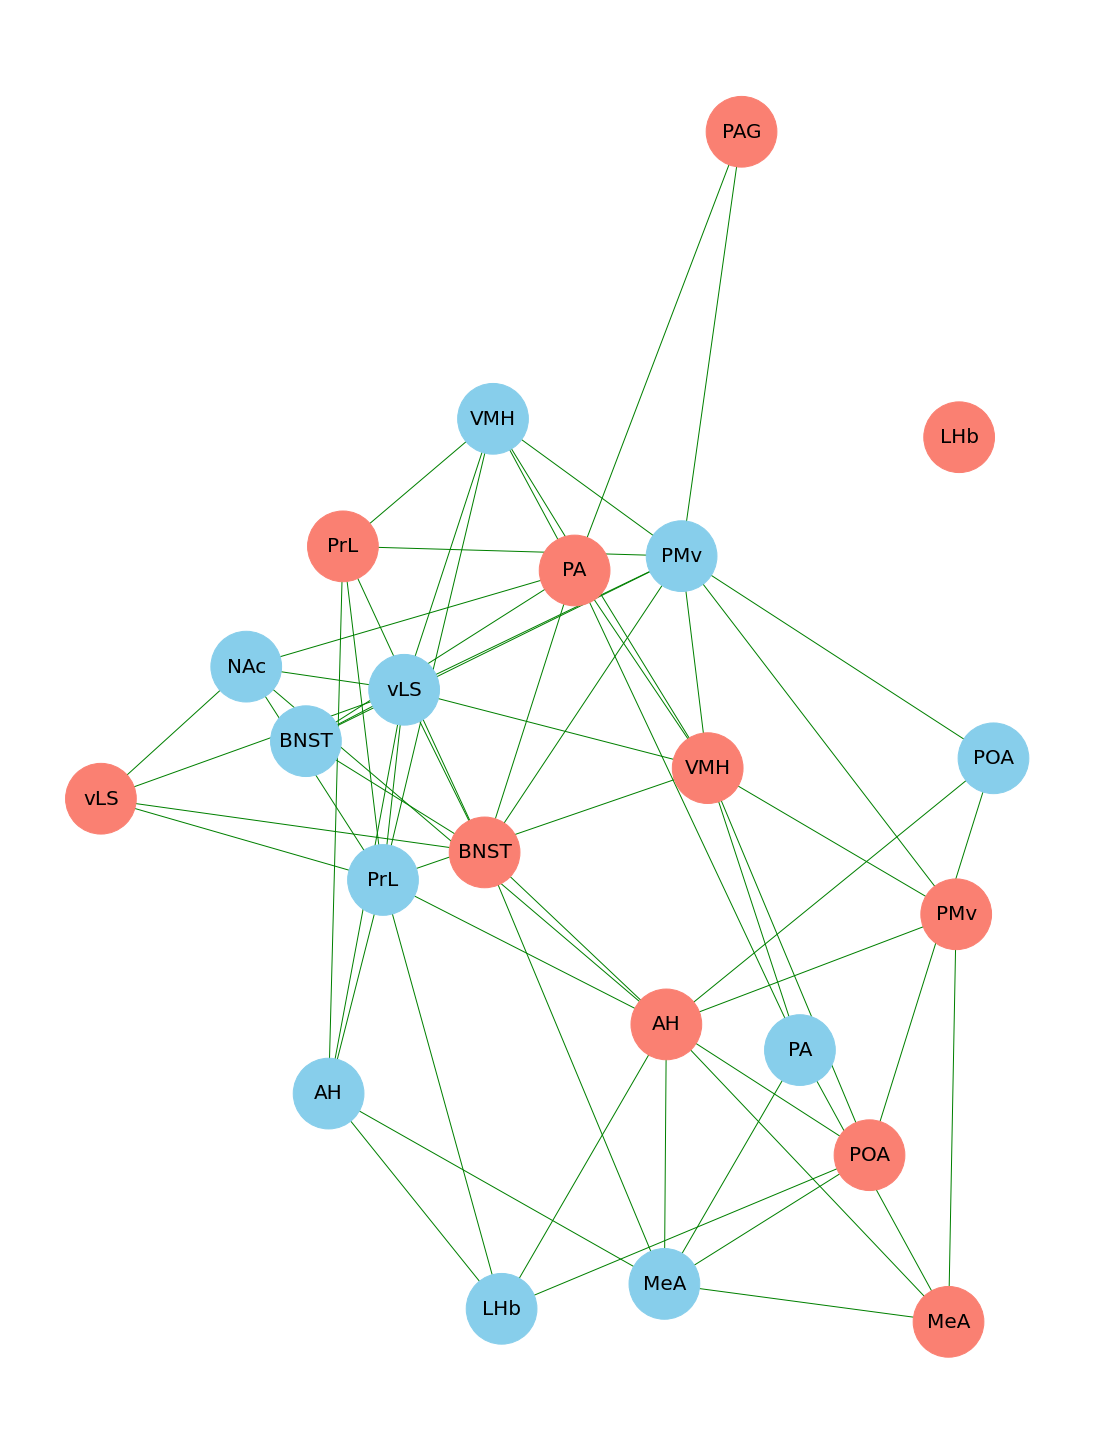

In [586]:
new_region_ids = [x.split(' ')[0] for x in region_ids]
mask = intercept_pvals_matrix < 0.05
adjacency_matrix = intercept_matrix * mask

# Create a graph using NetworkX.
G = nx.Graph()

# Add nodes to the graph (brain regions).
num_nodes = len(intercept_matrix)
G.add_nodes_from(range(num_nodes))
# Define colors for the nodes at specific indices.
node_colors = {i: 'salmon' if i in np.array([0, 2, 4, 6, 8, 10, 12, 14, 15, 17, 19]) else 'skyblue' for i in range(num_nodes)}

# Set node attributes for labels.
node_labels = {i: new_region_ids[i] for i in range(num_nodes)}
nx.set_node_attributes(G, node_labels, "label")
nx.set_node_attributes(G, node_colors, "color")

# Add edges to the graph based on the adjacency matrix.
edges = np.argwhere(adjacency_matrix > 0)
G.add_edges_from(edges)

# Perform the force-directed layout.
max_distance = 25  # Adjust this value to set the desired maximum distance.
k = 1 / np.sqrt(max_distance)
pos = nx.spring_layout(G, seed=42, k=k)  # You can choose different layouts if needed.
pos[17] = np.array([0.09, 0.09])

# Extract node colors from node attributes.
node_colors = nx.get_node_attributes(G, "color").values()

# Draw the graph.
plt.figure(figsize=(15, 20))
node_labels = nx.get_node_attributes(G, "label")
nx.draw(G, pos, with_labels=True, node_size=5000, labels=node_labels, node_color=node_colors, font_size=20, font_color='black', edge_color='green')
# plt.title("Brain Connectivity Graph")

posx and posy should be finite values


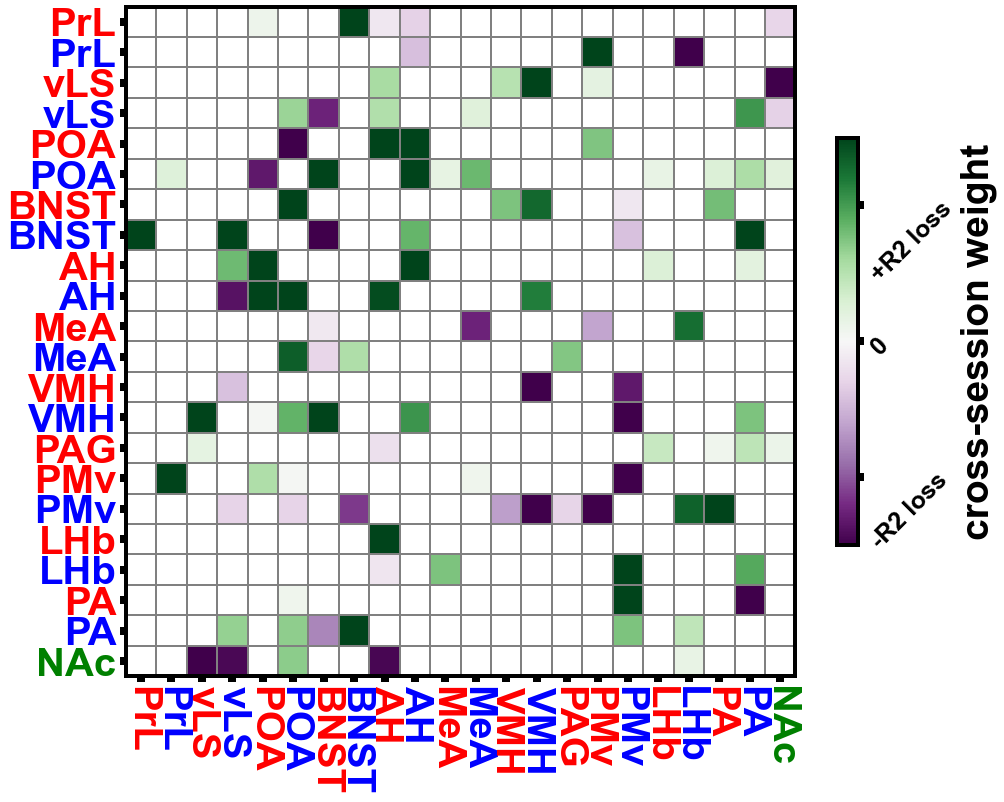

In [94]:
from matplotlib.colors import Normalize, TwoSlopeNorm
norm = TwoSlopeNorm(vmin=-0.003, vcenter=0., vmax=0.003)

# Create a mask for p-values less than 0.05
mask = cum_pvals_matrix < 0.05

# Set the masked regions to NaN in the magnitude matrix
cum_matrix_mask = cum_matrix.copy()
cum_matrix_mask[~mask] = np.nan

# Regular plotting with p-value color coding
plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('PRGn')  # You can change the colormap as needed
im = plt.imshow(cum_matrix_mask, cmap=cmap, norm=norm, interpolation='nearest')
# plt.grid(True, color='black', linewidth=5)
plt.xticks(np.arange(22), np.array([x.split(' ')[0] for x in region_ids]), rotation=270, weight='bold', fontfamily='Arial', fontsize=40);
plt.yticks(np.arange(22), np.array([x.split(' ')[0] for x in region_ids]), weight='bold', fontfamily='Arial', fontsize=40);
cbar = plt.colorbar(im, shrink=0.5)
cbar.set_label("cross-session weight", fontfamily='Arial', fontsize=39, weight='bold')
cbar.set_ticks([-0.002, 0, 0.002])
cbar.set_ticklabels(['-R2 loss', 0, '+R2 loss'], fontfamily='Arial', fontsize=25, weight='bold', rotation=45)

# Minor ticks
ax = plt.gca();
ax.set_xticks(np.arange(-.5, 22, 1), minor=True)
ax.set_yticks(np.arange(-.5, 22, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='gray', linestyle='-', linewidth=2)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)

# Get the current y tick labels
ytick_labels = plt.gca().yaxis.get_ticklabels()
xtick_labels = plt.gca().xaxis.get_ticklabels()

# Define colors for each y tick label
colorcode = ['red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'red', 'red', 'blue', 'red', 'blue', 'red', 'blue', 'green']
# Iterate through y tick labels and set their colors
for ylabel, xlabel, color in zip(ytick_labels, xtick_labels, colorcode):
    ylabel.set_color(color)
    xlabel.set_color(color)
plt.savefig('R2_loss_cumul.png', dpi=600, bbox_inches='tight')

posx and posy should be finite values


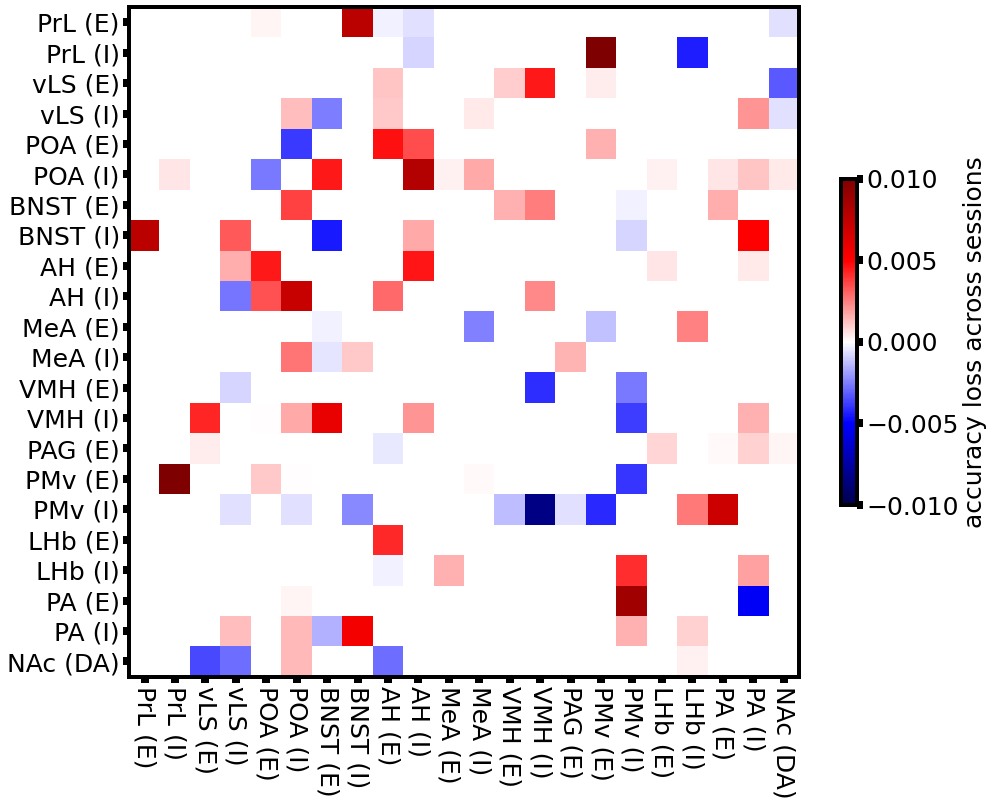

In [370]:
from matplotlib.colors import Normalize, TwoSlopeNorm
norm = TwoSlopeNorm(vmin=-0.01, vcenter=0., vmax=0.01)

# Create a mask for p-values less than 0.05
mask = cum_pvals_matrix < 0.05

# Set the masked regions to NaN in the magnitude matrix
cum_matrix_mask = cum_matrix.copy()
cum_matrix_mask[~mask] = np.nan

plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('seismic')  # You can change the colormap as needed
im = plt.imshow(cum_matrix_mask, cmap=cmap, norm=norm)
plt.xticks(np.arange(22), region_ids, rotation=270);
plt.yticks(np.arange(22), region_ids);
plt.colorbar(im, label='accuracy loss across sessions', shrink=0.4)

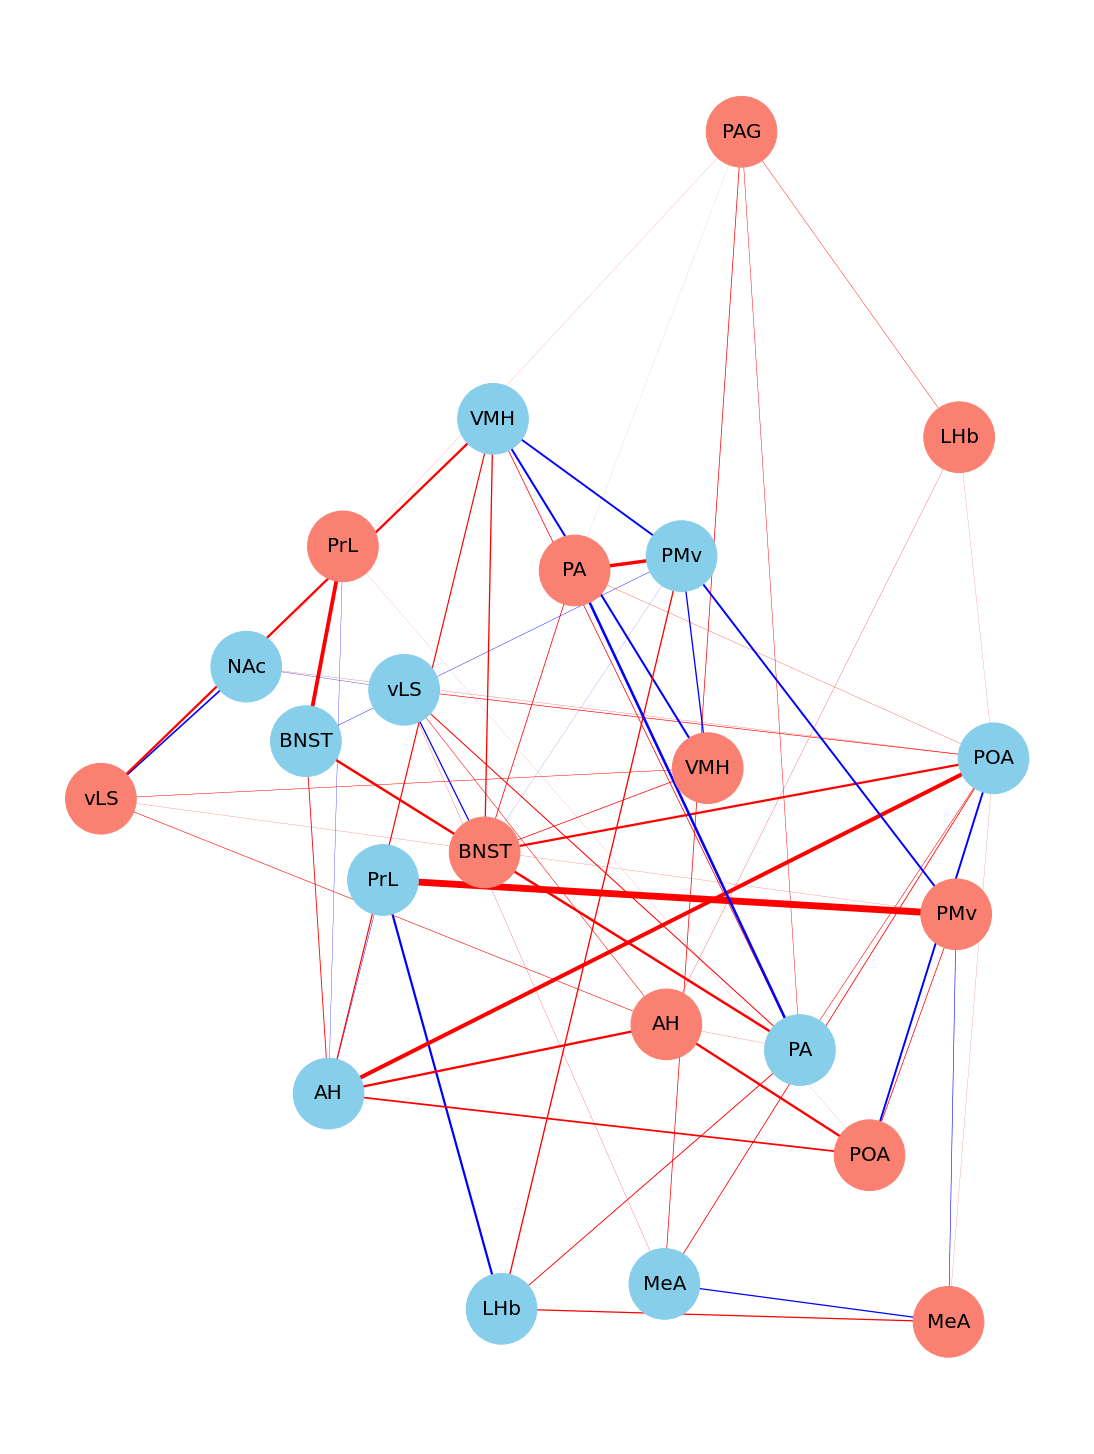

In [571]:
# Load the original node attributes (labels and colors).
node_labels = nx.get_node_attributes(G, "label")
node_colors = nx.get_node_attributes(G, "color")

# Get new adjacency matrix
mask = cum_pvals_matrix < 0.05
new_adjacency_matrix = cum_matrix * mask


# Update the edges of the graph with the new adjacency matrix.
for u, v in G.edges():
    G[u][v]['weight'] = new_adjacency_matrix[u][v]

# Extract updated edge weights from edge attributes.
edge_weights = [G[u][v]['weight']*500 for u, v in G.edges()]

# Define edge colors based on the sign of the edge weights.
edge_colors = ['red' if weight >= 0 else 'blue' for weight in edge_weights]

# Draw the graph with labels, color-coded nodes, and updated edge widths.
plt.figure(figsize=(15, 20))
nx.draw(G, pos, with_labels=True, node_size=5000, labels=node_labels, node_color=node_colors.values(), font_size=20, font_color='black', width=edge_weights, edge_color=edge_colors)
# plt.title("Brain Connectivity Graph")
plt.show()

Summary of encoding results using weights

In [362]:
# putting everything together to get big matrix for each region with significance

intercept_matrix = np.zeros((22, 22))
intercept_matrix[:] = np.nan
intercept_pvals_matrix = intercept_matrix.copy()
cum_matrix = intercept_matrix.copy()
cum_pvals_matrix = intercept_matrix.copy()

for q, region2quant in enumerate(region_ids):
    print('Testing ', region2quant)
    region_idx = indices[region2quant]
    other_idxs = np.asarray([i for i, x in enumerate(region_ids) if region2quant !=x])
    all_tables = {}
    weights2map = np.transpose(np.abs(agg_animal_weights[:, region_idx, :sessions2exclude, :]), [1, 0, 2])
    
    # prep table
    for r, roi in enumerate(region_ids):

        r_vals = np.concatenate(weights2map[:, r, :].T)
        trials = np.hstack([np.arange(total_sessions) for i in np.arange(12)]).astype(int)
        days = np.hstack([np.hstack([np.repeat(i, 3) for i in np.arange((total_sessions)/3)]) for i in np.arange(12)]).astype(int)
        sessions =np.hstack([np.concatenate([np.hstack([np.arange(3) for i in np.arange(((total_sessions)/3))])]) for i in np.arange(12)]).astype(int)
        subjects = np.hstack([np.repeat(i, total_sessions) for i in np.arange(12)])
        table = pd.DataFrame(np.concatenate([trials.reshape(1,-1), days.reshape(1,-1), sessions.reshape(1,-1), subjects.reshape(1,-1), r_vals.reshape(1,-1)], axis=0).T)
        table = table.dropna(axis=0)
        all_tables[roi] = table
    new_region_ids = [x for x in region_ids if region2quant != x]
    all_roi_results = []
    
    # fit model
    for roi in new_region_ids:
        print(roi)
        sample = all_tables[roi]
        new_column_names = ['cum_trial', 'day_trial', 'session_trial', 'subject', 'dependent_variable']
        column_name_mapping = {old_column: new_column for old_column, new_column in zip(sample.columns, new_column_names)}
        sample = sample.rename(columns=column_name_mapping)
        sample = sample.reset_index(drop=True)
        sample = sample.dropna(axis=0)
        results = fit_model(sample)
        all_roi_results.append(results)
        
    # save results
    cond=0
    intercept_results = []
    intercept_pvals = []
    for i, roi in enumerate(new_region_ids):
        # Extract result
        EI_result=all_roi_results[i].params['Intercept']
        pval=all_roi_results[i].pvalues[cond]
        intercept_results.append(EI_result)
        intercept_pvals.append(pval)
    intercept_results = np.asarray(intercept_results)
    intercept_matrix[q, other_idxs] = intercept_results
    intercept_pvals = np.asarray(intercept_pvals)    
    intercept_pvals_matrix[q, other_idxs] = intercept_pvals
        
    cond = 2
    cum_pvals = []
    cum_results = []
    for i, roi in enumerate(new_region_ids):
        # Extract result
        EI_result=all_roi_results[i].params['cum_trial']
        cum_results.append(EI_result)
        pval=all_roi_results[i].pvalues[cond]
        cum_pvals.append(pval)
    cum_results = np.asarray(cum_results)
    cum_pvals = np.asarray(cum_pvals)
    cum_matrix[q, other_idxs] = cum_results
    cum_pvals_matrix[q, other_idxs] = cum_pvals
    

Testing  PrL (E)
PrL (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0284            
Min. group size:  24      Log-Likelihood:     65.8105           
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.512      0.070   7.312   0.000    0.375    0.649
session_trial   0.016      0.013   1.230   0.219   -0.009    0.041
cum_trial       0.000      0.002   0.150   0.881   -0.003    0.003
subject Var     0.048      0.134                                  

vLS (E)
             Mixed Linear Model Regression Results
Model

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0176            
Min. group size:  24      Log-Likelihood:     109.6319          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.215     0.031   6.912  0.000   0.154   0.276
session_trial     -0.002     0.011  -0.163  0.871  -0.024   0.020
cum_trial         -0.003     0.001  -2.015  0.044  -0.005  -0.000
subject Var        0.005     0.023                               

BNST (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0023            
Min. group size:  24      Log-Likelihood:     373.5071          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.058      0.007   8.151   0.000    0.044    0.072
session_trial   0.001      0.004   0.320   0.749   -0.006    0.009
cum_trial       0.000      0.000   1.006   0.314   -0.000    0.001
subject Var     0.000      0.001                                  

PAG (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0008            
Min. group size:  24      Log-Likelihood:     346.6615          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.026     0.005   5.491  0.000   0.017   0.035
session_trial      0.005     0.003   1.794  0.073  -0.000   0.010
cum_trial         -0.000     0.000  -1.086  0.278  -0.001   0.000
subject Var        0.000     0.001                               

PMv (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0203            
Min. group size:  24      Log-Likelihood:     110.9375          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.402     0.051   7.942  0.000   0.303   0.502
session_trial      0.003     0.011   0.240  0.810  -0.019   0.024
cum_trial         -0.001     0.001  -0.859  0.390  -0.004   0.001
subject Var        0.024     0.080                               

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0084            
Min. group size:  24      Log-Likelihood:     213.1376          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.103     0.018   5.783  0.000   0.068   0.138
session_trial      0.016     0.007   2.251  0.024   0.002   0.031
cum_trial         -0.002     0.001  -2.251  0.024  -0.004  -0.000
subject Var        0.001     0.010                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0062            
Min. group size:  24      Log-Likelihood:     165.6508          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.043     0.035   1.241  0.215  -0.025   0.111
session_trial     -0.006     0.007  -0.862  0.388  -0.021   0.008
cum_trial          0.004     0.001   4.615  0.000   0.002   0.006
subject Var        0.007     0.055                               

PMv (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dep

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

Testing  vLS (E)
PrL (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0009            
Min. group size:  24      Log-Likelihood:     521.7180          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.039      0.007   5.784   0.000    0.026    0.052
session_trial   0.002      0.002   1.008   0.314   -0.002    0.007
cum_trial       0.000      0.000   0.847   0.397   -0.000    0.001
subject Var     0.000      0.005                                  

PrL (I)
             Mixed Linear Model Regression Results
Model

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0062            
Min. group size:  24      Log-Likelihood:     244.5395          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.095     0.022   4.353  0.000   0.052   0.138
session_trial      0.014     0.006   2.187  0.029   0.001   0.026
cum_trial         -0.000     0.001  -0.013  0.990  -0.001   0.001
subject Var        0.004     0.023                               

AH (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0008            
Min. group size:  24      Log-Likelihood:     388.2174          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.032     0.009   3.635  0.000   0.015   0.049
session_trial      0.005     0.002   2.127  0.033   0.000   0.010
cum_trial         -0.000     0.000  -0.566  0.571  -0.001   0.000
subject Var        0.000     0.010                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0029            
Min. group size:  24      Log-Likelihood:     365.6253          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.236     0.019  12.327  0.000   0.198   0.273
session_trial     -0.002     0.004  -0.485  0.628  -0.010   0.006
cum_trial          0.001     0.000   1.137  0.256  -0.000   0.001
subject Var        0.003     0.030                               

Testing  vLS (I)
PrL (E)
             Mixed Linear Model Regression Results
Model:            Mi

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0312            
Min. group size:  24      Log-Likelihood:     44.6945           
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.384     0.108   3.545  0.000   0.172   0.597
session_trial      0.039     0.014   2.746  0.006   0.011   0.066
cum_trial         -0.000     0.002  -0.145  0.885  -0.003   0.003
subject Var        0.111     0.306                               

AH (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0016            
Min. group size:  24      Log-Likelihood:     324.3333          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.047     0.011   4.229  0.000   0.025   0.069
session_trial      0.004     0.004   1.110  0.267  -0.003   0.011
cum_trial         -0.000     0.000  -0.152  0.879  -0.001   0.001
subject Var        0.001     0.010                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0029            
Min. group size:  24      Log-Likelihood:     373.3040          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.100     0.012   8.656  0.000   0.078   0.123
session_trial      0.001     0.004   0.309  0.757  -0.007   0.009
cum_trial         -0.002     0.000  -4.471  0.000  -0.003  -0.001
subject Var        0.001     0.009                               

Testing  POA (E)
PrL (E)
             Mixed Linear Model Regression Results
Model:            Mi

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0067            
Min. group size:  24      Log-Likelihood:     185.9112          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.151     0.023   6.423  0.000   0.105   0.197
session_trial     -0.013     0.007  -1.844  0.065  -0.028   0.001
cum_trial          0.001     0.001   1.332  0.183  -0.001   0.003
subject Var        0.003     0.022                               

BNST (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.war

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0005            
Min. group size:  24      Log-Likelihood:     491.8587          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.029     0.003   8.342  0.000   0.022   0.036
session_trial     -0.001     0.002  -0.369  0.712  -0.004   0.003
cum_trial         -0.000     0.000  -1.882  0.060  -0.001   0.000
subject Var        0.000     0.001                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0016            
Min. group size:  24      Log-Likelihood:     317.1459          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.079     0.017   4.673  0.000   0.046   0.112
session_trial      0.001     0.004   0.343  0.732  -0.006   0.008
cum_trial         -0.001     0.000  -2.679  0.007  -0.002  -0.000
subject Var        0.002     0.027                               

LHb (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0011            
Min. group size:  24      Log-Likelihood:     454.8123          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.058     0.006   9.294  0.000   0.046   0.070
session_trial     -0.007     0.003  -2.775  0.006  -0.012  -0.002
cum_trial         -0.001     0.000  -2.105  0.035  -0.001  -0.000
subject Var        0.000     0.003                               

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

MeA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0003            
Min. group size:  24      Log-Likelihood:     555.7052          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.023     0.003   6.988  0.000   0.016   0.029
session_trial     -0.001     0.001  -0.862  0.389  -0.004   0.002
cum_trial         -0.000     0.000  -0.672  0.501  -0.000   0.000
subject Var        0.000     0.002                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dep

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0004            
Min. group size:  24      Log-Likelihood:     397.5293          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.026     0.004   7.529  0.000   0.020   0.033
session_trial     -0.002     0.002  -1.211  0.226  -0.006   0.001
cum_trial         -0.000     0.000  -1.795  0.073  -0.001   0.000
subject Var        0.000     0.001                               

PMv (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0009            
Min. group size:  24      Log-Likelihood:     428.3962          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.050     0.007   7.070  0.000   0.036   0.063
session_trial     -0.009     0.002  -3.463  0.001  -0.014  -0.004
cum_trial         -0.000     0.000  -1.021  0.307  -0.001   0.000
subject Var        0.000     0.005                               

PrL (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0043            
Min. group size:  24      Log-Likelihood:     251.6912          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.165     0.034   4.898  0.000   0.099   0.232
session_trial     -0.010     0.006  -1.868  0.062  -0.021   0.001
cum_trial         -0.001     0.001  -0.975  0.330  -0.002   0.001
subject Var        0.009     0.074                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0004            
Min. group size:  24      Log-Likelihood:     441.0189          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.031     0.008   3.981  0.000   0.016   0.046
session_trial     -0.003     0.002  -1.691  0.091  -0.007   0.001
cum_trial         -0.000     0.000  -0.925  0.355  -0.001   0.000
subject Var        0.000     0.011                               

PMv (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0139            
Min. group size:  24      Log-Likelihood:     129.6842          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.024     0.047   0.514  0.607  -0.068   0.116
session_trial     -0.001     0.010  -0.073  0.942  -0.020   0.019
cum_trial          0.006     0.001   5.483  0.000   0.004   0.009
subject Var        0.017     0.076                               

PrL (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0080            
Min. group size:  24      Log-Likelihood:     189.5736          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.090      0.031   2.891   0.004    0.029    0.152
session_trial   0.012      0.008   1.590   0.112   -0.003    0.027
cum_trial       0.002      0.001   2.415   0.016    0.000    0.004
subject Var     0.007      0.043                                  

MeA (E)


C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.war

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0004            
Min. group size:  24      Log-Likelihood:     523.1931          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.024     0.003   7.099  0.000   0.017   0.031
session_trial     -0.002     0.002  -1.309  0.191  -0.005   0.001
cum_trial         -0.000     0.000  -0.208  0.835  -0.000   0.000
subject Var        0.000     0.001                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0025            
Min. group size:  24      Log-Likelihood:     315.3922          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.044      0.016   2.752   0.006    0.013    0.076
session_trial   0.003      0.004   0.817   0.414   -0.005    0.012
cum_trial       0.001      0.000   1.440   0.150   -0.000    0.002
subject Var     0.002      0.020                                  

LHb (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0022            
Min. group size:  24      Log-Likelihood:     372.3316          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.050     0.009   5.570  0.000   0.032   0.067
session_trial     -0.003     0.004  -0.682  0.495  -0.010   0.005
cum_trial          0.001     0.000   1.540  0.124  -0.000   0.002
subject Var        0.000     0.005                               

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0101            
Min. group size:  24      Log-Likelihood:     184.2861          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.205      0.033   6.184   0.000    0.140    0.270
session_trial   0.007      0.008   0.936   0.349   -0.008    0.023
cum_trial       0.002      0.001   1.606   0.108   -0.000    0.003
subject Var     0.009      0.045                                  

MeA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0023            
Min. group size:  24      Log-Likelihood:     367.0607          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.082     0.008   9.903  0.000   0.066   0.098
session_trial     -0.009     0.004  -2.340  0.019  -0.017  -0.001
cum_trial         -0.001     0.000  -3.133  0.002  -0.002  -0.001
subject Var        0.000     0.003                               

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0082            
Min. group size:  24      Log-Likelihood:     203.8789          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.199     0.047   4.259  0.000   0.107   0.291
session_trial     -0.008     0.007  -1.173  0.241  -0.023   0.006
cum_trial          0.002     0.001   2.912  0.004   0.001   0.004
subject Var        0.020     0.108                               

MeA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0031            
Min. group size:  24      Log-Likelihood:     294.1499          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.084     0.016   5.390  0.000   0.053   0.114
session_trial     -0.011     0.005  -2.268  0.023  -0.020  -0.001
cum_trial          0.000     0.001   0.243  0.808  -0.001   0.001
subject Var        0.002     0.015                               

VMH (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization w

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0005            
Min. group size:  24      Log-Likelihood:     382.3208          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.027     0.004   7.082  0.000   0.020   0.035
session_trial      0.000     0.002   0.057  0.954  -0.004   0.004
cum_trial         -0.000     0.000  -0.633  0.527  -0.001   0.000
subject Var        0.000     0.001                               

PMv (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0344            
Min. group size:  24      Log-Likelihood:     36.8231           
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.262     0.051   5.181  0.000   0.163   0.361
session_trial     -0.011     0.016  -0.736  0.461  -0.042   0.019
cum_trial         -0.002     0.002  -1.091  0.275  -0.006   0.002
subject Var        0.016     0.048                               

BNST (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0160            
Min. group size:  24      Log-Likelihood:     102.7184          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.166     0.045   3.723  0.000   0.079   0.254
session_trial      0.002     0.011   0.184  0.854  -0.020   0.024
cum_trial         -0.004     0.001  -2.688  0.007  -0.006  -0.001
subject Var        0.013     0.058                               

PMv (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

MeA (I)
PrL (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0041            
Min. group size:  24      Log-Likelihood:     299.7721          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.072     0.011   6.389  0.000   0.050   0.095
session_trial      0.007     0.005   1.467  0.142  -0.003   0.017
cum_trial         -0.001     0.001  -0.923  0.356  -0.002   0.001
subject Var        0.000     0.005                               

PrL (I)
             Mixed Linear Model Regression Results
Model:            Mix

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0065            
Min. group size:  24      Log-Likelihood:     267.6991          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.093     0.015   6.004  0.000   0.063   0.123
session_trial     -0.002     0.006  -0.394  0.694  -0.014   0.010
cum_trial         -0.001     0.001  -1.062  0.288  -0.002   0.001
subject Var        0.001     0.009                               

VMH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0042            
Min. group size:  24      Log-Likelihood:     265.6069          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.087     0.013   6.936  0.000   0.063   0.112
session_trial      0.000     0.005   0.082  0.935  -0.010   0.011
cum_trial         -0.001     0.001  -2.026  0.043  -0.003  -0.000
subject Var        0.001     0.006                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0324            
Min. group size:  24      Log-Likelihood:     56.8595           
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.194     0.038   5.087  0.000   0.119   0.269
session_trial     -0.012     0.014  -0.851  0.395  -0.038   0.015
cum_trial         -0.003     0.002  -1.572  0.116  -0.006   0.001
subject Var        0.009     0.027                               

POA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0039            
Min. group size:  24      Log-Likelihood:     336.9511          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.068     0.011   6.291  0.000   0.047   0.089
session_trial      0.002     0.005   0.324  0.746  -0.008   0.011
cum_trial         -0.001     0.001  -1.369  0.171  -0.002   0.000
subject Var        0.000     0.005                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0168            
Min. group size:  24      Log-Likelihood:     105.2044          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.204     0.024   8.689  0.000   0.158   0.251
session_trial      0.001     0.012   0.087  0.931  -0.022   0.024
cum_trial         -0.005     0.001  -3.452  0.001  -0.007  -0.002
subject Var        0.001     0.007                               

PA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 264     Method:             REML              
No. Groups:       11      Scale:              0.0013            
Min. group size:  24      Log-Likelihood:     472.9658          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.052     0.008   6.765  0.000   0.037   0.067
session_trial     -0.003     0.003  -0.972  0.331  -0.008   0.003
cum_trial         -0.001     0.000  -2.274  0.023  -0.001  -0.000
subject Var        0.000     0.005                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0012            
Min. group size:  24      Log-Likelihood:     390.3741          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.058     0.015   3.886  0.000   0.029   0.087
session_trial      0.001     0.003   0.467  0.641  -0.004   0.007
cum_trial         -0.001     0.000  -2.159  0.031  -0.001  -0.000
subject Var        0.002     0.027                               

PA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0017            
Min. group size:  24      Log-Likelihood:     325.0843          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.035     0.007   4.967  0.000   0.021   0.049
session_trial     -0.003     0.004  -0.713  0.476  -0.010   0.005
cum_trial          0.001     0.000   2.663  0.008   0.000   0.002
subject Var        0.000     0.002                               

POA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0008            
Min. group size:  24      Log-Likelihood:     388.6039          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.026     0.008   3.320  0.001   0.011   0.042
session_trial      0.002     0.003   0.849  0.396  -0.003   0.007
cum_trial         -0.000     0.000  -1.346  0.178  -0.001   0.000
subject Var        0.000     0.007                               

MeA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0105            
Min. group size:  24      Log-Likelihood:     146.8091          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.089     0.022   3.959  0.000   0.045   0.132
session_trial     -0.004     0.009  -0.462  0.644  -0.022   0.014
cum_trial          0.001     0.001   0.620  0.535  -0.001   0.003
subject Var        0.002     0.012                               

PA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Ma

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0041            
Min. group size:  24      Log-Likelihood:     205.9699          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.074     0.013   5.569  0.000   0.048   0.101
session_trial     -0.003     0.006  -0.545  0.586  -0.015   0.009
cum_trial          0.000     0.001   0.083  0.934  -0.001   0.001
subject Var        0.000     0.005                               

PrL (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.1171            
Min. group size:  24      Log-Likelihood:     -78.3823          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.724     0.194   3.722  0.000   0.343   1.105
session_trial      0.083     0.033   2.548  0.011   0.019   0.147
cum_trial         -0.006     0.004  -1.632  0.103  -0.014   0.001
subject Var        0.241     0.423                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0708            
Min. group size:  24      Log-Likelihood:     -32.6755          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.505     0.055   9.183  0.000   0.397   0.613
session_trial      0.002     0.024   0.082  0.935  -0.044   0.048
cum_trial         -0.011     0.003  -3.915  0.000  -0.016  -0.005
subject Var        0.010     0.026                               

LHb (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0081            
Min. group size:  24      Log-Likelihood:     149.7882          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.080     0.019   4.183  0.000   0.042   0.117
session_trial     -0.009     0.009  -1.078  0.281  -0.026   0.008
cum_trial          0.001     0.001   0.644  0.519  -0.001   0.003
subject Var        0.001     0.008                               

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 168     Method:             REML              
No. Groups:       7       Scale:              0.0135            
Min. group size:  24      Log-Likelihood:     108.4150          
Max. group size:  24      Converged:          No                
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.142     0.024   6.023  0.000   0.096   0.188
session_trial     -0.013     0.011  -1.182  0.237  -0.035   0.009
cum_trial         -0.000     0.001  -0.099  0.921  -0.003   0.002
subject Var        0.001     0.008                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0058            
Min. group size:  24      Log-Likelihood:     201.3664          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.198     0.019  10.227  0.000   0.160   0.236
session_trial     -0.026     0.007  -3.877  0.000  -0.040  -0.013
cum_trial         -0.004     0.001  -4.698  0.000  -0.005  -0.002
subject Var        0.002     0.015                               

LHb (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0030            
Min. group size:  24      Log-Likelihood:     257.9567          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.071      0.023   3.158   0.002    0.027    0.115
session_trial   0.000      0.005   0.091   0.927   -0.009    0.010
cum_trial       0.002      0.001   3.668   0.000    0.001    0.003
subject Var     0.003      0.035                                  

PrL (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0110            
Min. group size:  24      Log-Likelihood:     158.9996          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.106      0.026   4.078   0.000    0.055    0.157
session_trial   0.008      0.009   0.856   0.392   -0.010    0.025
cum_trial       0.001      0.001   0.940   0.347   -0.001    0.003
subject Var     0.004      0.021                                  

AH (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Depen

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0022            
Min. group size:  24      Log-Likelihood:     296.1391          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.027      0.010   2.721   0.007    0.008    0.047
session_trial   0.003      0.004   0.806   0.420   -0.005    0.011
cum_trial       0.001      0.000   1.257   0.209   -0.000    0.002
subject Var     0.000      0.005                                  

PMv (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0085            
Min. group size:  24      Log-Likelihood:     165.6244          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.169     0.022   7.764  0.000   0.126   0.212
session_trial     -0.005     0.008  -0.578  0.563  -0.021   0.011
cum_trial         -0.002     0.001  -1.645  0.100  -0.003   0.000
subject Var        0.002     0.014                               

vLS (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0034            
Min. group size:  24      Log-Likelihood:     254.0065          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.087     0.013   6.928  0.000   0.063   0.112
session_trial     -0.001     0.005  -0.192  0.848  -0.011   0.009
cum_trial         -0.001     0.001  -2.164  0.030  -0.003  -0.000
subject Var        0.001     0.007                               

AH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0016            
Min. group size:  24      Log-Likelihood:     360.8389          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.065     0.013   5.127  0.000   0.040   0.089
session_trial     -0.002     0.003  -0.692  0.489  -0.009   0.004
cum_trial         -0.000     0.000  -0.363  0.717  -0.001   0.001
subject Var        0.001     0.015                               

PA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Va

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0141            
Min. group size:  24      Log-Likelihood:     132.8756          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.143     0.029   4.849  0.000   0.085   0.201
session_trial     -0.008     0.010  -0.790  0.430  -0.027   0.012
cum_trial          0.001     0.001   0.489  0.625  -0.002   0.003
subject Var        0.005     0.024                               

POA (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0174            
Min. group size:  24      Log-Likelihood:     109.7693          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.125     0.034   3.673  0.000   0.058   0.192
session_trial     -0.015     0.011  -1.367  0.172  -0.037   0.007
cum_trial          0.003     0.001   2.015  0.044   0.000   0.005
subject Var        0.007     0.030                               

VMH (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0712            
Min. group size:  24      Log-Likelihood:     -40.1622          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.590     0.070   8.467  0.000   0.453   0.727
session_trial     -0.037     0.022  -1.668  0.095  -0.081   0.007
cum_trial         -0.008     0.003  -3.159  0.002  -0.014  -0.003
subject Var        0.029     0.062                               

NAc (DA)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent 

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 192     Method:             REML              
No. Groups:       8       Scale:              0.0144            
Min. group size:  24      Log-Likelihood:     113.6903          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.133      0.037   3.574   0.000    0.060    0.206
session_trial   0.010      0.011   0.943   0.346   -0.011    0.031
cum_trial       0.000      0.001   0.205   0.837   -0.002    0.003
subject Var     0.008      0.040                                  

POA (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Depe

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0051            
Min. group size:  24      Log-Likelihood:     243.0520          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.086     0.016   5.431  0.000   0.055   0.117
session_trial      0.000     0.006   0.004  0.997  -0.012   0.012
cum_trial         -0.000     0.001  -0.629  0.529  -0.002   0.001
subject Var        0.001     0.010                               

VMH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0049            
Min. group size:  24      Log-Likelihood:     247.4273          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.069     0.014   4.807  0.000   0.041   0.097
session_trial     -0.001     0.006  -0.153  0.879  -0.012   0.011
cum_trial          0.000     0.001   0.693  0.488  -0.001   0.002
subject Var        0.001     0.008                               

Testing  NAc (DA)
PrL (E)
             Mixed Linear Model Regression Results
Model:            M

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0196            
Min. group size:  24      Log-Likelihood:     109.0625          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.099      0.034   2.929   0.003    0.033    0.165
session_trial   0.017      0.011   1.567   0.117   -0.004    0.039
cum_trial       0.003      0.001   2.504   0.012    0.001    0.006
subject Var     0.007      0.028                                  

BNST (E)
             Mixed Linear Model Regression Results
Model:            MixedLM Dep

C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the paramete

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 240     Method:             REML              
No. Groups:       10      Scale:              0.0033            
Min. group size:  24      Log-Likelihood:     320.7801          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
-----------------------------------------------------------------
                  Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.094     0.013   7.433  0.000   0.069   0.119
session_trial      0.003     0.005   0.567  0.570  -0.006   0.012
cum_trial         -0.001     0.001  -2.458  0.014  -0.002  -0.000
subject Var        0.001     0.009                               

VMH (I)
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent V

             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: dependent_variable
No. Observations: 216     Method:             REML              
No. Groups:       9       Scale:              0.0022            
Min. group size:  24      Log-Likelihood:     333.3048          
Max. group size:  24      Converged:          Yes               
Mean group size:  24.0                                          
------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
------------------------------------------------------------------
Intercept       0.036      0.010   3.629   0.000    0.016    0.055
session_trial   0.005      0.004   1.251   0.211   -0.003    0.013
cum_trial       0.000      0.000   0.987   0.324   -0.000    0.001
subject Var     0.000      0.006                                  



C:\Users\Jorge\anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


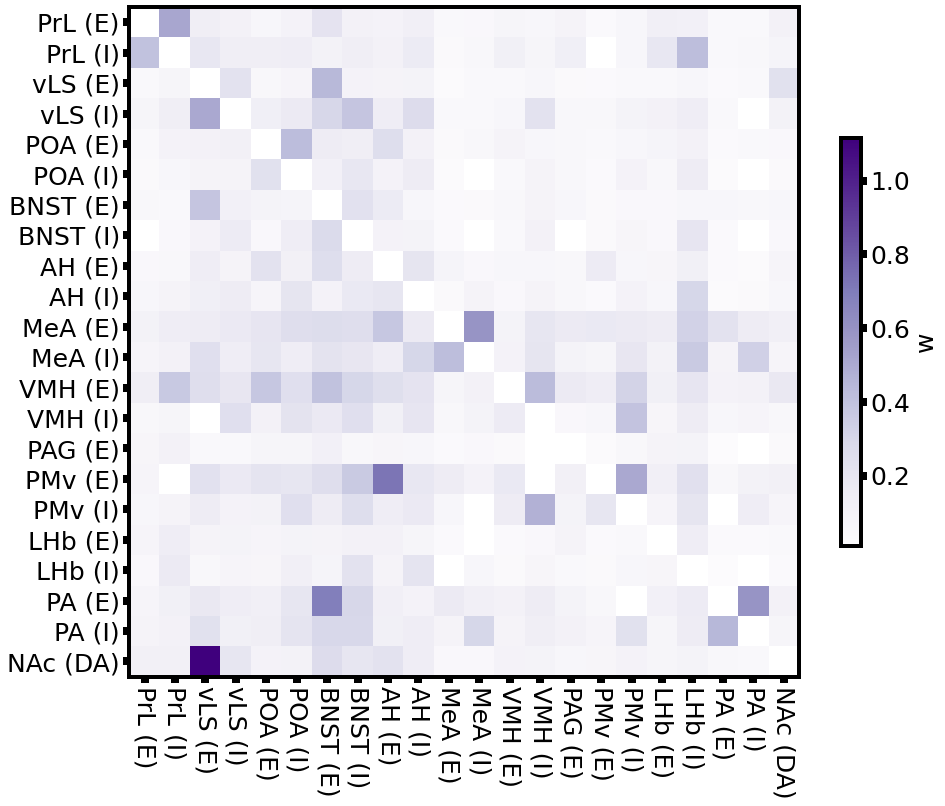

In [364]:
# Create a mask for p-values less than 0.05
mask = intercept_pvals_matrix < 0.05
norm = TwoSlopeNorm(vmin=-0.5, vcenter=0., vmax=0.5)

# Set the masked regions to NaN in the magnitude matrix
intercept_matrix_mask = intercept_matrix.copy()
intercept_matrix_mask[~mask] = np.nan

# Regular plotting with p-value color coding
plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('Purples')  # You can change the colormap as needed
im = plt.imshow(intercept_matrix_mask, cmap=cmap, interpolation='nearest')
plt.xticks(np.arange(22), region_ids, rotation=270);
plt.yticks(np.arange(22), region_ids);
plt.colorbar(im, label='w', shrink=0.5)

posx and posy should be finite values


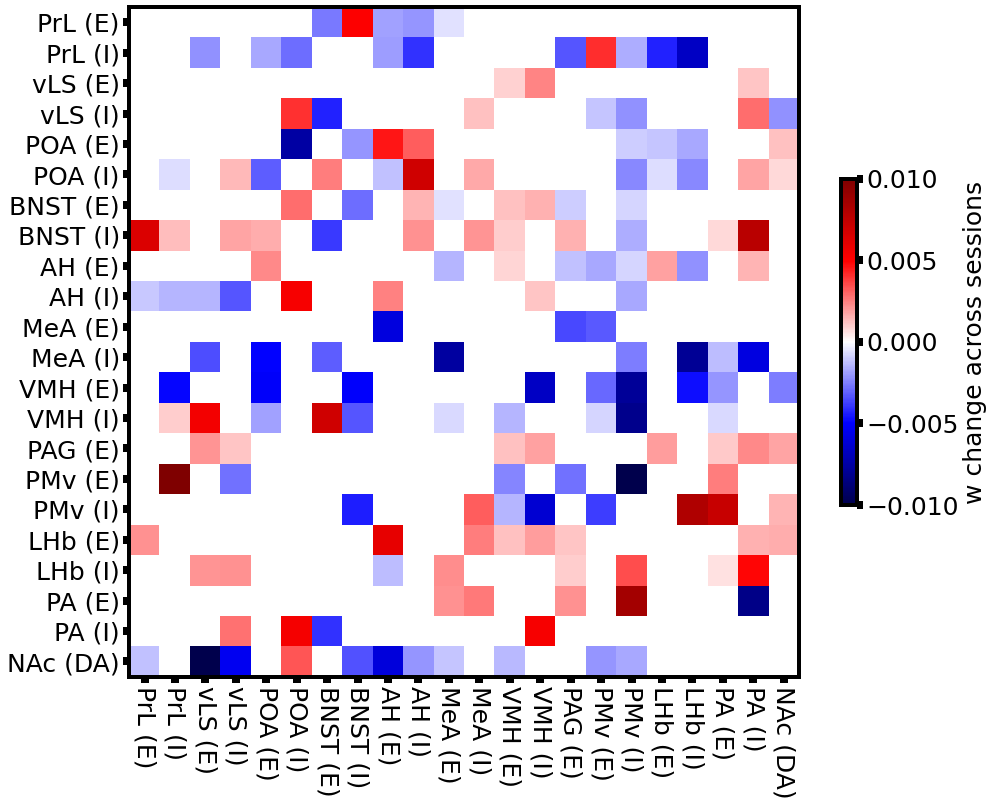

In [367]:
from matplotlib.colors import Normalize, TwoSlopeNorm
norm = TwoSlopeNorm(vmin=-0.01, vcenter=0., vmax=0.01)

# Create a mask for p-values less than 0.05
mask = cum_pvals_matrix < 0.05

# Set the masked regions to NaN in the magnitude matrix
cum_matrix_mask = cum_matrix.copy()
cum_matrix_mask[~mask] = np.nan

plt.figure(figsize=(15, 15))
cmap = plt.get_cmap('seismic')  # You can change the colormap as needed
im = plt.imshow(cum_matrix_mask, cmap=cmap, norm=norm)
plt.xticks(np.arange(22), region_ids, rotation=270);
plt.yticks(np.arange(22), region_ids);
plt.colorbar(im, label='w change across sessions', shrink=0.4)

3. Whole trace cross correlation

In [618]:
def draw_xcorrs(cc_data, num_lags=20, rois=False):
    
    cc_data = cc_data[:, :, rois]
    num_trials, num_elements, num_features = cc_data.shape
    
    # calculate cross-correlations
    cc_matrices = np.zeros((num_features, num_features, num_lags*2+1, num_trials))
    cc_matrices[:] = np.nan

    for t in range(num_trials):
        for i in range(num_features):
            for j in range(num_features):
                if i == j:
                    continue

                X = cc_data[t, :, i] # select trial of feature
                if np.any(np.isreal(X)):
                    X = X[~np.isnan(X)]
                    
                Y = cc_data[t, :, j]
                if np.any(np.isreal(Y)):
                    Y = Y[~np.isnan(Y)]
                
                if len(X) > 0 and len(Y) > 0:
                    
                    cc = np.zeros(num_lags*2+1)
                    for lag in range(-num_lags, num_lags+1):
                        cc[num_lags+lag] = np.correlate(X, np.roll(Y, lag)) / (np.sqrt(np.sum(X**2)) * np.sqrt(np.sum(Y**2)))

                    cc_matrices[i, j, :, t] = cc
                
    return cc_matrices

### Run xcorrs
regions2cc = np.asarray([12, 13, 14])
num_variables = len(regions2cc)
n = 40 * 32
num_lags = int(n/2)
diff = n - num_lags
cc_matrices = {}

for a, animal in enumerate(agg_animals):
    
    print('Processing data for %s' % animal)
    
    # load animal data
    trial_comps, rois = format4analysis(full_data, animal)
    rois = rois[:-3]
    norm_indices = [i for i, item in enumerate(region_ids) if item in set(rois)]
    trial_comps = np.concatenate(trial_comps, axis=2)
    trial_comps = np.transpose(trial_comps, [2, 0, 1])
    concatenated_ccs = draw_xcorrs(trial_comps, num_lags=num_lags, rois=regions2cc)
    cc_matrices[animal] = concatenated_ccs

Processing data for 3095
Processing data for 3096
Processing data for 3097
Processing data for 4013
Processing data for 4014
Processing data for 4015
Processing data for 4016
Processing data for 91R2
Processing data for 30L
Processing data for 30B
Processing data for 30R2
Processing data for 29L


In [637]:
all_PAG_traces = np.zeros((641, 27, 12))
for a, animal in enumerate(cc_matrices.keys()):
    xcorr_traces = cc_matrices[animal][0, 2, int(num_lags/2):-int(num_lags/2), :]
    all_PAG_traces[:, :, a] = xcorr_traces

In [644]:
mean_traces.shape

(641, 27)

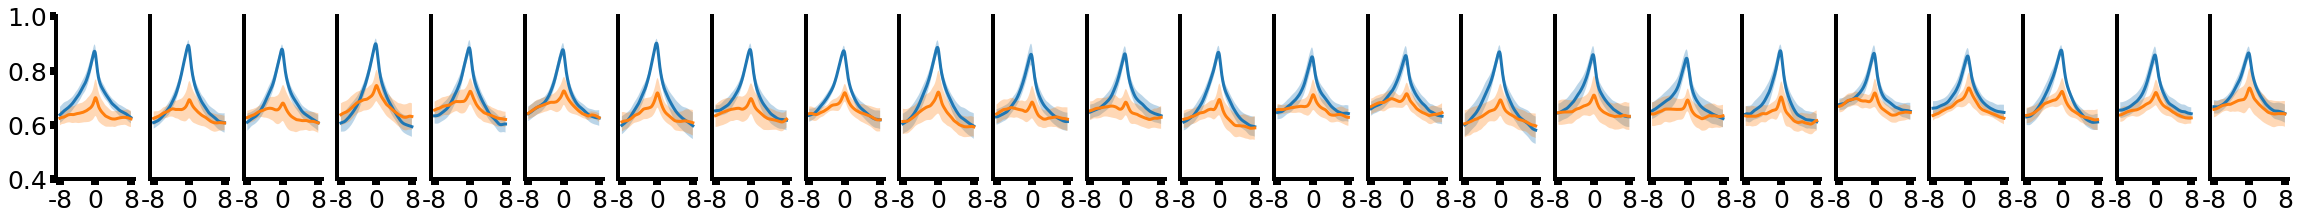

In [654]:
from scipy.stats import sem

all_VMH_traces = np.zeros((641, 27, 12))
for a, animal in enumerate(cc_matrices.keys()):
    xcorr_traces = cc_matrices[animal][0, 1, int(num_lags/2):-int(num_lags/2), :]
    all_VMH_traces[:, :, a] = xcorr_traces

mean_traces = np.nanmean(all_VMH_traces, axis=2)
mean_ci = sem(all_VMH_traces, axis=2, nan_policy='omit')*1.96

fig, ax = plt.subplots(1, 24, figsize=(40, 3))
for i in np.arange(24):
    ax[i].fill_between(np.arange(641), mean_traces[:, i]-mean_ci[:, i], mean_traces[:, i]+mean_ci[:, i], alpha=0.3)
    ax[i].plot(np.arange(641),  mean_traces[:, i], linewidth=3)
    ax[i].set_ylim(top=1, bottom=0.4)
    
all_PAG_traces = np.zeros((641, 27, 12))
for a, animal in enumerate(cc_matrices.keys()):
    xcorr_traces = cc_matrices[animal][0, 2, int(num_lags/2):-int(num_lags/2), :]
    all_PAG_traces[:, :, a] = xcorr_traces
    
mean_traces = np.nanmean(all_PAG_traces, axis=2)
mean_ci = sem(all_PAG_traces, axis=2, nan_policy='omit')*1.96
    
for i in np.arange(24):
    ax[i].fill_between(np.arange(641), mean_traces[:, i]-mean_ci[:, i], mean_traces[:, i]+mean_ci[:, i], alpha=0.3)
    ax[i].plot(np.arange(641),  mean_traces[:, i], linewidth=3)
    ax[i].set_ylim(top=1, bottom=0.4)
    ax[i].set_xticks(np.linspace(0, 640, 3), np.linspace(-8, 8, 3).astype(int))
    if i != 0:
        ax[i].set_yticks([])
    
sns.despine()


C:\Users\Jorge\AppData\Local\Temp\ipykernel_27632\2221695829.py:20: RuntimeWarning: Mean of empty slice
  ax[a, 24].plot(np.nanmean(cc_matrices[animal][0, 2, int(num_lags/2):-int(num_lags/2), :], axis=1))
C:\Users\Jorge\AppData\Local\Temp\ipykernel_27632\2221695829.py:20: RuntimeWarning: Mean of empty slice
  ax[a, 24].plot(np.nanmean(cc_matrices[animal][0, 2, int(num_lags/2):-int(num_lags/2), :], axis=1))
C:\Users\Jorge\AppData\Local\Temp\ipykernel_27632\2221695829.py:19: RuntimeWarning: Mean of empty slice
  ax[a, 24].plot(np.nanmean(cc_matrices[animal][0, 1, int(num_lags/2):-int(num_lags/2), :], axis=1))
C:\Users\Jorge\AppData\Local\Temp\ipykernel_27632\2221695829.py:20: RuntimeWarning: Mean of empty slice
  ax[a, 24].plot(np.nanmean(cc_matrices[animal][0, 2, int(num_lags/2):-int(num_lags/2), :], axis=1))
C:\Users\Jorge\AppData\Local\Temp\ipykernel_27632\2221695829.py:20: RuntimeWarning: Mean of empty slice
  ax[a, 24].plot(np.nanmean(cc_matrices[animal][0, 2, int(num_lags/2):-int(n

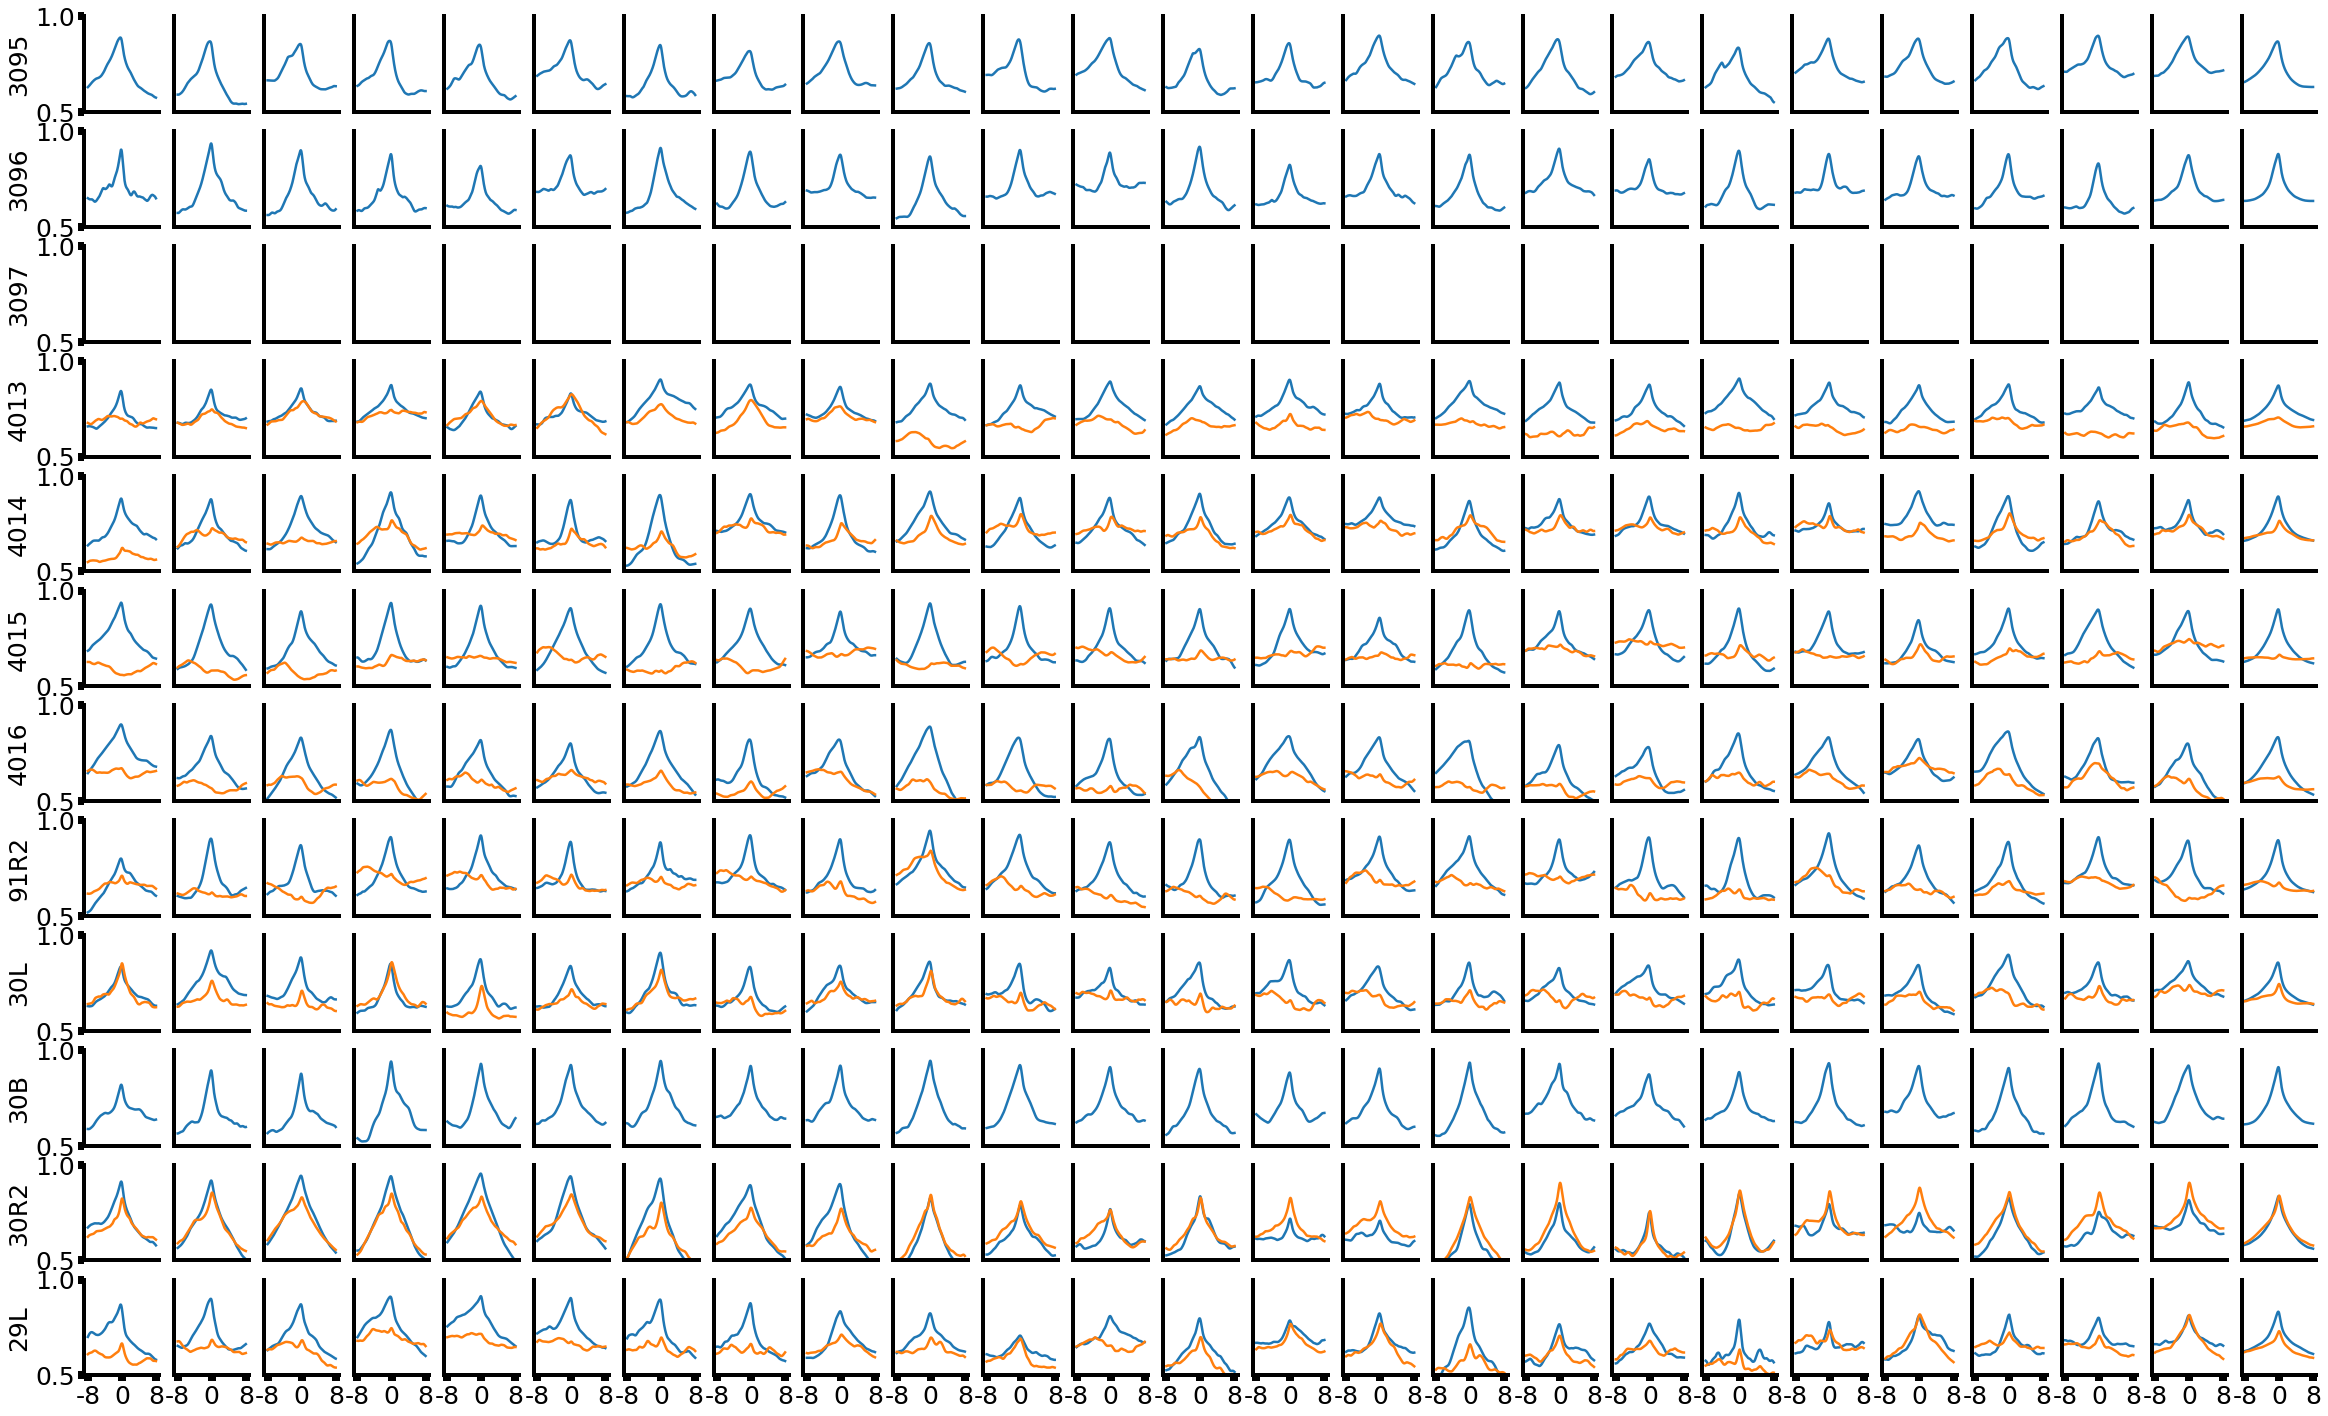

In [636]:
fig, ax = plt.subplots(12, 25, figsize=(40, 25))
for a, animal in enumerate(agg_animals):
    for trial in np.arange(24):
        VMH_I = cc_matrices[animal][0, 1, int(num_lags/2):-int(num_lags/2), trial]
        PAG = cc_matrices[animal][0, 2, int(num_lags/2):-int(num_lags/2), trial]
        ax[a, trial].plot(VMH_I)
        ax[a, trial].plot(PAG)
        ax[a, trial].set_ylim(top=1, bottom=0.5)
        if a == 11:
            ax[a, trial].set_xticks(np.linspace(0, 640, 3), np.linspace(-8, 8, 3).astype(int))
        else:
            ax[a, trial].set_xticks([])
        
        if trial != 0:
            ax[a, trial].set_yticks([])
        else:
             ax[a, trial].set_ylabel(animal)
    
    ax[a, 24].plot(np.nanmean(cc_matrices[animal][0, 1, int(num_lags/2):-int(num_lags/2), :], axis=1))
    ax[a, 24].plot(np.nanmean(cc_matrices[animal][0, 2, int(num_lags/2):-int(num_lags/2), :], axis=1))
    ax[a, 24].set_yticks([])
    ax[a, 24].set_ylim(top=1, bottom=0.5)
    if a == 11:
        ax[a, 24].set_xticks(np.linspace(0, 640, 3), np.linspace(-8, 8, 3).astype(int))
    else:
        ax[a, 24].set_xticks([])
            
sns.despine()